# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 4 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.9891 # 1-(60/5*24)/50977

MODE_TRAIN_AE = False
MODE_AUTO_SELECT = 2  # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

48

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_52116/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53561  1688599500000   1914.61   1914.93  1913.51    1914.33    451.4832   
53562  1688599800000   1914.33   1914.33  1912.15    1912.75    458.3916   
53563  1688600100000   1912.76   1915.58  1912.75    1915.29    595.6626   
53564  1688600400000   1915.29   1915.30  1914.62    1915.10    312.3015   
53565  1688600700000   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00       1909.702500       1911.015000   
53562  2023-07-05 23:30:00       1909.815000       1911.015000   
53563  2023-07-05 23:35:00       1909.935000       1911.015000   
53564  2023-07-05 23:40:00       1909.935000       1911.015000   
53565  2023-07-05 23:45:00       1909.912500       1911.015000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
53561        1911.125  ...   NaN         NaN            NaN           NaN   
53562        1911.125  ...   NaN         NaN            NaN           NaN   
53563        1911.125  ...   NaN         NaN            NaN           NaN   
53564        1911.125  ...   NaN         NaN            NaN           NaN   
53565        1911.125  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53561               NaN         0.0               NaN         0.0      0.0   
53562               NaN         0.0               NaN         0.0      0.0   
53563               NaN         0.0               NaN         0.0      0.0   
53564               NaN         0.0               NaN         0.0      0.0   
53565               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
53561   NaN  
53562   NaN  
53563   NaN  
53564   NaN  
53565   NaN  

[53566 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53561  1688599500000   1914.61   1914.93  1913.51    1914.33    451.4832   
53562  1688599800000   1914.33   1914.33  1912.15    1912.75    458.3916   
53563  1688600100000   1912.76   1915.58  1912.75    1915.29    595.6626   
53564  1688600400000   1915.29   1915.30  1914.62    1915.10    312.3015   
53565  1688600700000   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00       1909.702500       1911.015000   
53562  2023-07-05 23:30:00       1909.815000       1911.015000   
53563  2023-07-05 23:35:00       1909.935000       1911.015000   
53564  2023-07-05 23:40:00       1909.935000       1911.015000   
53565  2023-07-05 23:45:00       1909.912500       1911.015000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
53561        1911.125  ...   NaN         NaN            NaN           NaN   
53562        1911.125  ...   NaN         NaN            NaN           NaN   
53563        1911.125  ...   NaN         NaN            NaN           NaN   
53564        1911.125  ...   NaN         NaN            NaN           NaN   
53565        1911.125  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53561               NaN         0.0               NaN         0.0      0.0   
53562               NaN         0.0               NaN         0.0      0.0   
53563               NaN         0.0               NaN         0.0      0.0   
53564               NaN         0.0               NaN         0.0      0.0   
53565               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
53561                  NaN  
53562                  NaN  
53563                  NaN  
53564                  NaN  
53565                  NaN  

[53566 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       513
delta_event_real    513
delta_event_pred    513
Previous_num        513
Actual_num          513
Event               513
Date                513
Previous            513
Consensus           513
Actual              513
Country             513
Time (ET)           513
keep                513
date                513
dtype: int64

on 53566 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
53561   1914.61   1914.93  1913.51    1914.33    451.4832   
53562   1914.33   1914.33  1912.15    1912.75    458.3916   
53563   1912.76   1915.58  1912.75    1915.29    595.6626   
53564   1915.29   1915.30  1914.62    1915.10    312.3015   
53565   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00       1909.702500       1911.015000   
53562  2023-07-05 23:30:00       1909.815000       1911.015000   
53563  2023-07-05 23:35:00       1909.935000       1911.015000   
53564  2023-07-05 23:40:00       1909.935000       1911.015000   
53565  2023-07-05 23:45:00       1909.912500       1911.015000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
53561        1911.125         1910.795  ...  1874.506493  1833.253279   
53562        1911.125         1910.795  ...  1874.511150  1833.255949   
53563        1911.125         1911.120  ...  1874.519967  1833.259395   
53564        1911.125         1911.120  ...  1874.527595  1833.261365   
53565        1911.125         1911.300  ...  1874.539059  1833.263989   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
53561  1861.094632  1828.231463   1719.162909          1.056625  0.101951   
53562  1861.100982  1828.230632   1719.163951          1.048065  0.101208   
53563  1861.104720  1828.231661   1719.165316          1.061809  0.102399   
53564  1861.109907  1828.231084   1719.166034          1.060776  0.102310   
53565  1861.114362  1828.230002   1719.166590          1.056062  0.101902   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.871741  
1      1.205254e+08      522461.0       17.871741  
2      1.205254e+08      522461.0       17.871741  
3      1.205254e+08      522461.0       17.871741  
4      1.205254e+08      522461.0       17.871741  
...             ...           ...             ...  
53561  1.202191e+08      468827.0       19.115248  
53562  1.202191e+08      468827.0       19.115248  
53563  1.202191e+08      468827.0       19.115248  
53564  1.202191e+08      468827.0       19.115248  
53565  1.202191e+08      468827.0       19.115248  

[53566 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [21]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [22]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [23]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [24]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [25]:
df_feat.shape[0]

53566

In [26]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

52982

In [27]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53561  1688599500000   1914.61   1914.93  1913.51    1914.33    451.4832   
53562  1688599800000   1914.33   1914.33  1912.15    1912.75    458.3916   
53563  1688600100000   1912.76   1915.58  1912.75    1915.29    595.6626   
53564  1688600400000   1915.29   1915.30  1914.62    1915.10    312.3015   
53565  1688600700000   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00       1909.702500       1911.015000   
53562  2023-07-05 23:30:00       1909.815000       1911.015000   
53563  2023-07-05 23:35:00       1909.935000       1911.015000   
53564  2023-07-05 23:40:00       1909.935000       1911.015000   
53565  2023-07-05 23:45:00       1909.912500       1911.015000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53561        1911.125  ...         NaN            NaN           NaN   
53562        1911.125  ...         NaN            NaN           NaN   
53563        1911.125  ...         NaN            NaN           NaN   
53564        1911.125  ...         NaN            NaN           NaN   
53565        1911.125  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53561               NaN         0.0               NaN         0.0      0.0   
53562               NaN         0.0               NaN         0.0      0.0   
53563               NaN         0.0               NaN         0.0      0.0   
53564               NaN         0.0               NaN         0.0      0.0   
53565               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53561                  NaN  False  
53562                  NaN  False  
53563                  NaN  False  
53564                  NaN  False  
53565                  NaN  False  

[53566 rows x 136 columns]

In [28]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
52978  1688424600000   1954.90   1956.89  1954.51    1956.57    480.3683   
52979  1688424900000   1956.57   1956.58  1955.25    1955.34    395.7954   
52980  1688425200000   1955.34   1955.35  1953.82    1954.10    632.5556   
52981  1688425500000   1954.09   1954.10  1952.50    1953.01    643.1293   
52982  1688425800000   1953.01   1953.49  1951.55    1952.59    440.7057   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
52978  2023-07-03 22:50:00       1963.562500       1965.220000   
52979  2023-07-03 22:55:00       1963.562500       1965.220000   
52980  2023-07-03 23:00:00       1963.082500       1965.220000   
52981  2023-07-03 23:05:00       1962.535000       1965.240000   
52982  2023-07-03 23:10:00       1962.375000       1965.240000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
52978        1954.235  ...         0.0            0.0           0.0   
52979        1954.235  ...         0.0            0.0           0.0   
52980        1954.235  ...         0.0            0.0           0.0   
52981        1953.860  ...         0.0            0.0           0.0   
52982        1953.860  ...         0.0            0.0           0.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
52978               0.0         0.0               0.0         0.0      0.0   
52979               0.0         0.0               0.0         0.0      0.0   
52980               0.0         0.0               0.0         0.0      0.0   
52981               0.0         0.0               0.0         0.0      0.0   
52982               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
52978  2023-07-04 05:00:00   True  
52979  2023-07-04 05:00:00   True  
52980  2023-07-04 05:00:00   True  
52981  2023-07-04 05:00:00   True  
52982  2023-07-04 05:00:00   True  

[52983 rows x 136 columns]

In [29]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
52983  1688426100000   1952.59   1953.20  1950.43    1952.86    827.7126   
52984  1688426400000   1952.86   1952.87  1951.80    1952.50    485.5644   
52985  1688426700000   1952.50   1953.39  1952.20    1953.39    317.2315   
52986  1688427000000   1953.38   1954.35  1952.71    1954.25    426.7197   
52987  1688427300000   1954.25   1955.26  1953.98    1954.53    461.8045   
...              ...       ...       ...      ...        ...         ...   
53561  1688599500000   1914.61   1914.93  1913.51    1914.33    451.4832   
53562  1688599800000   1914.33   1914.33  1912.15    1912.75    458.3916   
53563  1688600100000   1912.76   1915.58  1912.75    1915.29    595.6626   
53564  1688600400000   1915.29   1915.30  1914.62    1915.10    312.3015   
53565  1688600700000   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
52983  2023-07-03 23:15:00         1962.3750          1965.240   
52984  2023-07-03 23:20:00         1962.3400          1965.205   
52985  2023-07-03 23:25:00         1962.3400          1965.205   
52986  2023-07-03 23:30:00         1961.6775          1965.205   
52987  2023-07-03 23:35:00         1957.8500          1961.465   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00         1909.7025          1911.015   
53562  2023-07-05 23:30:00         1909.8150          1911.015   
53563  2023-07-05 23:35:00         1909.9350          1911.015   
53564  2023-07-05 23:40:00         1909.9350          1911.015   
53565  2023-07-05 23:45:00         1909.9125          1911.015   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
52983        1953.555  ...         0.0            0.0           0.0   
52984        1953.555  ...         0.0            0.0           0.0   
52985        1953.555  ...         0.0            0.0           0.0   
52986        1953.555  ...         0.0            0.0           0.0   
52987        1954.660  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53561        1911.125  ...         NaN            NaN           NaN   
53562        1911.125  ...         NaN            NaN           NaN   
53563        1911.125  ...         NaN            NaN           NaN   
53564        1911.125  ...         NaN            NaN           NaN   
53565        1911.125  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
52983               0.0         0.0               0.0         0.0      0.0   
52984               0.0         0.0               0.0         0.0      0.0   
52985               0.0         0.0               0.0         0.0      0.0   
52986               0.0         0.0               0.0         0.0      0.0   
52987               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53561               NaN         0.0               NaN         0.0      0.0   
53562               NaN         0.0               NaN         0.0      0.0   
53563               NaN         0.0               NaN         0.0      0.0   
53564               NaN         0.0               NaN         0.0      0.0   
53565               NaN         0.0               NaN         0.0      0.0   

                      date  train  
52983  2023-07-04 05:00:00  False  
52984  2023-07-04 05:00:00  False  
52985  2023-07-04 05:00:00  False  
52986  2023-07-04 05:00:00  False  
52987  2023-07-04 05:00:00  False  
...                    ...    ...  
53561                  NaN  False  
53562                  NaN  False  
53563                  NaN  False  
53564                  NaN  False  
53565                  NaN  False  

[583 rows x 136 columns]

In [30]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [31]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [32]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [33]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52920, 48, 104) (52920, 15)
(520, 48, 104) (520, 15)


In [34]:
X_train

array([[[1.00190948, 1.00175036, 1.00190948, ..., 0.        ,
         0.        , 0.        ],
        [1.00112224, 1.00190111, 1.00221936, ..., 0.        ,
         0.        , 0.        ],
        [1.00042712, 1.00112224, 1.00148236, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.        , 0.9999665 , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [1.00029312, 0.99999163, 1.00029312, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.00028475, 1.00029312, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00133189, 1.00211092, 1.00242924, ..., 0.        ,
         0.        , 0.        ],
        [1.00063663, 1.00133189, 1.00169209, ..., 0.        ,
         0.        , 0.        ],
        [1.00183449, 1.00063663, 1.00183449, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.0005026 , 1.00020104, 1.0005026 , ..., 0.        ,
         0.        , 0.        ],
        [1.0

In [35]:
seq_y

array([0.99977526, 0.99947902, 0.99856985, 0.99899379, 0.99978548,
       0.9993309 , 0.99956585, 0.99952499, 0.99898868, 0.99860561,
       0.99849835, 0.99935133, 0.99872308, 0.99808973, 0.997533  ])

In [36]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99919796, 1.00016858, 0.99994381, ..., 0.99866667, 0.9995198 ,
        0.99889145],
       [1.0009714 , 1.00074644, 1.00044991, ..., 1.0003221 , 0.99969324,
        0.99905928],
       [0.99977526, 0.99947902, 0.99856985, ..., 0.99872308, 0.99808973,
        0.997533  ]])

In [37]:
seq_y

array([0.99977526, 0.99947902, 0.99856985, 0.99899379, 0.99978548,
       0.9993309 , 0.99956585, 0.99952499, 0.99898868, 0.99860561,
       0.99849835, 0.99935133, 0.99872308, 0.99808973, 0.997533  ])

In [38]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99919796, 1.00016858, 0.99994381, ..., 0.99866667, 0.9995198 ,
        0.99889145],
       [1.0009714 , 1.00074644, 1.00044991, ..., 1.0003221 , 0.99969324,
        0.99905928],
       [0.99977526, 0.99947902, 0.99856985, ..., 0.99872308, 0.99808973,
        0.997533  ]])

In [39]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [40]:
X_train.shape

(52920, 48, 104)

In [41]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(52920, 48, 104) (52920, 15)
(520, 48, 104) (520, 15)


## Standardization

In [42]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [43]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99919796, 1.00016858, 0.99994381, ..., 0.99866667, 0.9995198 ,
        0.99889145],
       [1.0009714 , 1.00074644, 1.00044991, ..., 1.0003221 , 0.99969324,
        0.99905928],
       [0.99977526, 0.99947902, 0.99856985, ..., 0.99872308, 0.99808973,
        0.997533  ]])

In [44]:
np.mean(y_train_sca)

0.0005826929361030259

In [45]:
np.std(y_train_sca)

0.9986946757495884

In [46]:
np.mean(y_test_sca)

-0.11076900881842487

In [47]:
np.std(y_test_sca)

0.4639559901539646

### Check unscaling

In [48]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1727.532907       1726.877911   
1    1195.38   1196.31   1196.69  1194.90       1727.532907       1726.877911   
2    1194.55   1195.38   1195.81  1194.55       1727.532907       1726.877911   
3    1195.98   1194.55   1195.98  1194.31       1727.532907       1726.877911   
4    1196.06   1195.98   1196.37  1195.97       1727.532907       1726.877911   
5    1196.61   1196.06   1196.70  1196.06       1727.532907       1726.877911   
6    1194.36   1196.62   1196.62  1193.72       1727.532907       1726.877911   
7    1194.22   1194.37   1194.43  1192.72       1727.532907       1726.877911   
8    1193.64   1194.22   1194.22  1193.02       1727.532907       1726.877911   
9    1194.64   1193.64   1195.06  1193.63       1727.532907       1726.877911   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71            1730.72358   
1         1194.71          1194.71            1730.72358   
2         1194.71          1194.71            1730.72358   
3         1194.71          1194.71            1730.72358   
4         1194.71          1194.71            1730.72358   
5         1194.71          1194.71            1730.72358   
6         1194.71          1194.71            1730.72358   
7         1194.71          1194.71            1730.72358   
8         1194.71          1194.71            1730.72358   
9         1194.71          1194.71            1730.72358   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0           1718.658618  ...       0.0      0.62349    -0.781831   
1           1718.658618  ...       0.0      0.62349    -0.781831   
2           1718.658618  ...       0.0      0.62349    -0.781831   
3           1718.658618  ...       0.0      0.62349    -0.781831   
4           1718.658618  ...       0.0      0.62349    -0.781831   
5           1718.658618  ...       0.0      0.62349    -0.781831   
6           1718.658618  ...       0.0      0.62349    -0.781831   
7           1718.658618  ...       0.0      0.62349    -0.781831   
8           1718.658618  ...       0.0      0.62349    -0.781831   
9           1718.658618  ...       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin  day_off  \
0           0.97953          0.201299   0.866025        0.5      0.0   
1           0.97953          0.201299   0.866025        0.5      0.0   
2           0.97953          0.201299   0.866025        0.5      0.0   
3           0.97953          0.201299   0.866025        0.5      0.0   
4           0.97953          0.201299   0.866025        0.5      0.0   
5           0.97953          0.201299   0.866025        0.5      0.0   
6           0.97953          0.201299   0.866025        0.5      0.0   
7           0.97953          0.201299   0.866025        0.5      0.0   
8           0.97953          0.201299   0.866025        0.5      0.0   
9           0.97953          0.201299   0.866025        0.5      0.0   

   event_pred  event_real  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  
5         0.0         0.0  
6         0.0         0.0  
7         0.0         0.0  
8         0.0         0.0  
9         0.0         0.0  

[10 rows x 104 columns]

In [49]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [50]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [51]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [52]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [53]:
X_train_sca.shape

(52920, 48, 104)

In [54]:
X_train_sca[:,-1,:].shape

(52920, 104)

In [55]:
y_train_sca[:,0][:, np.newaxis]

array([[-0.06617876],
       [-0.20703854],
       [-0.04908362],
       ...,
       [-0.2008462 ],
       [ 0.20212019],
       [-0.06966988]])

In [56]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(52920, 105)

In [57]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [58]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [59]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

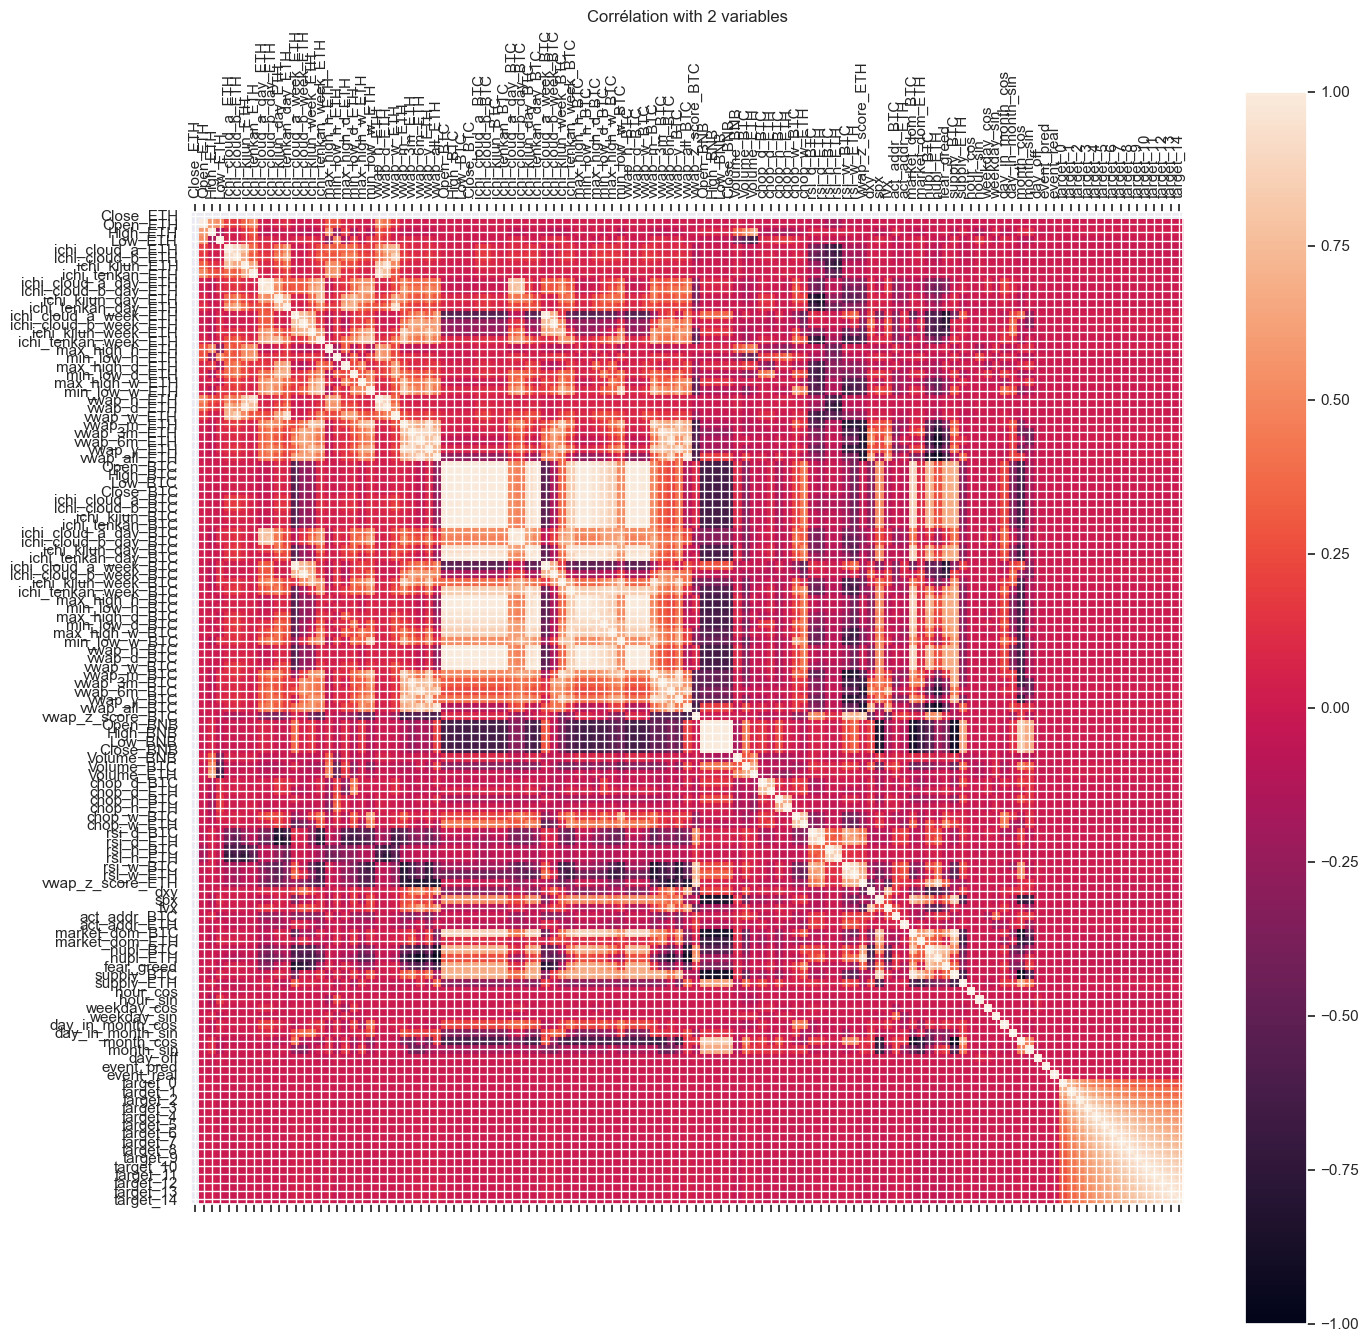

In [60]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


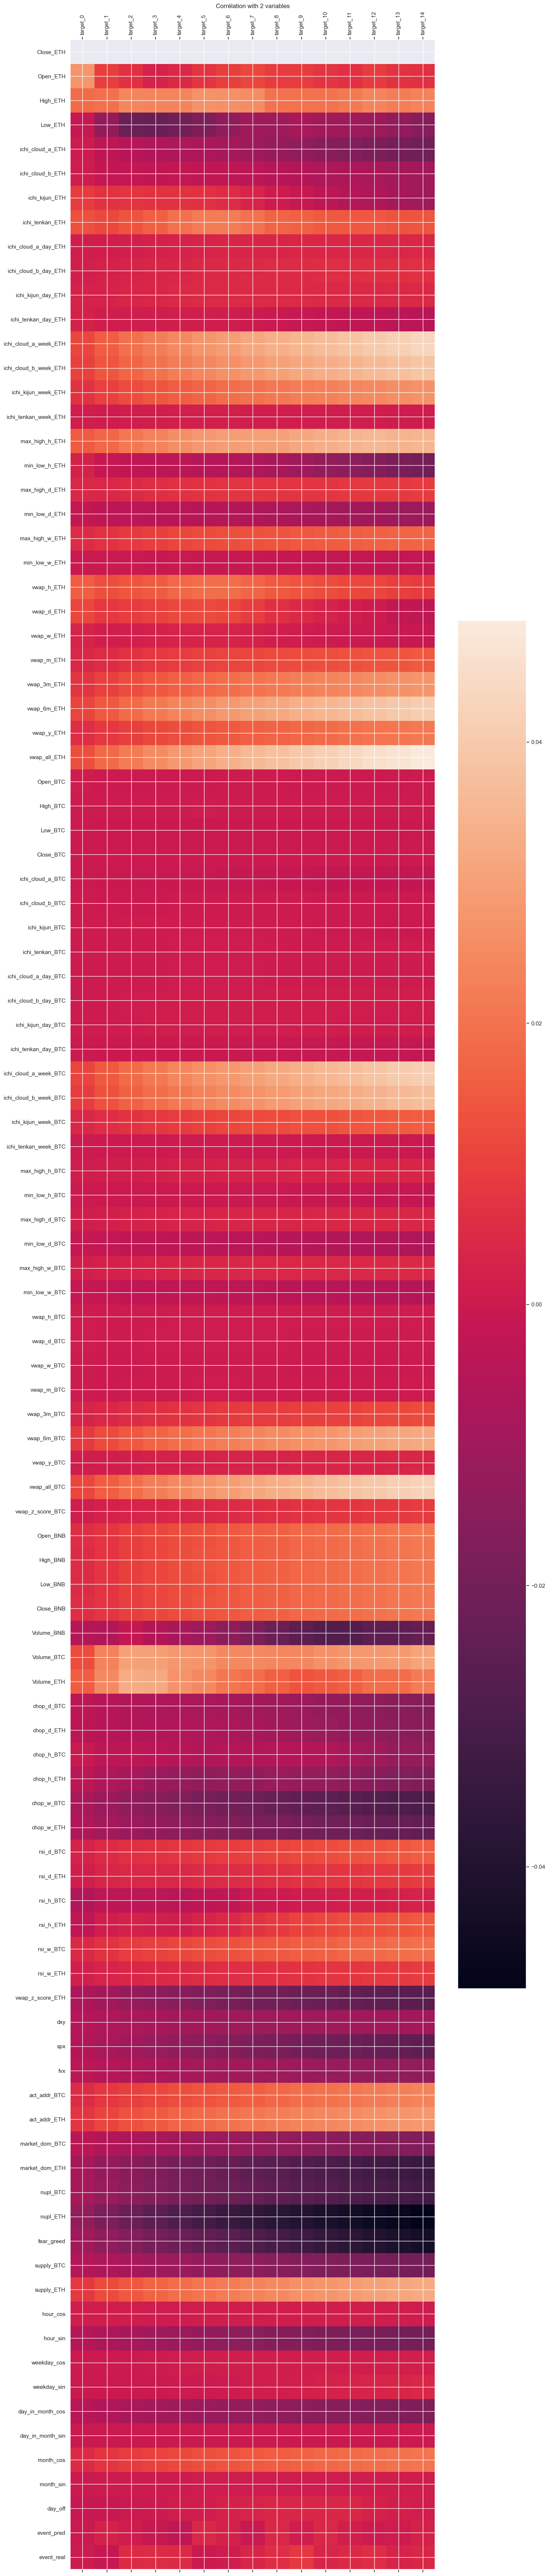

In [61]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


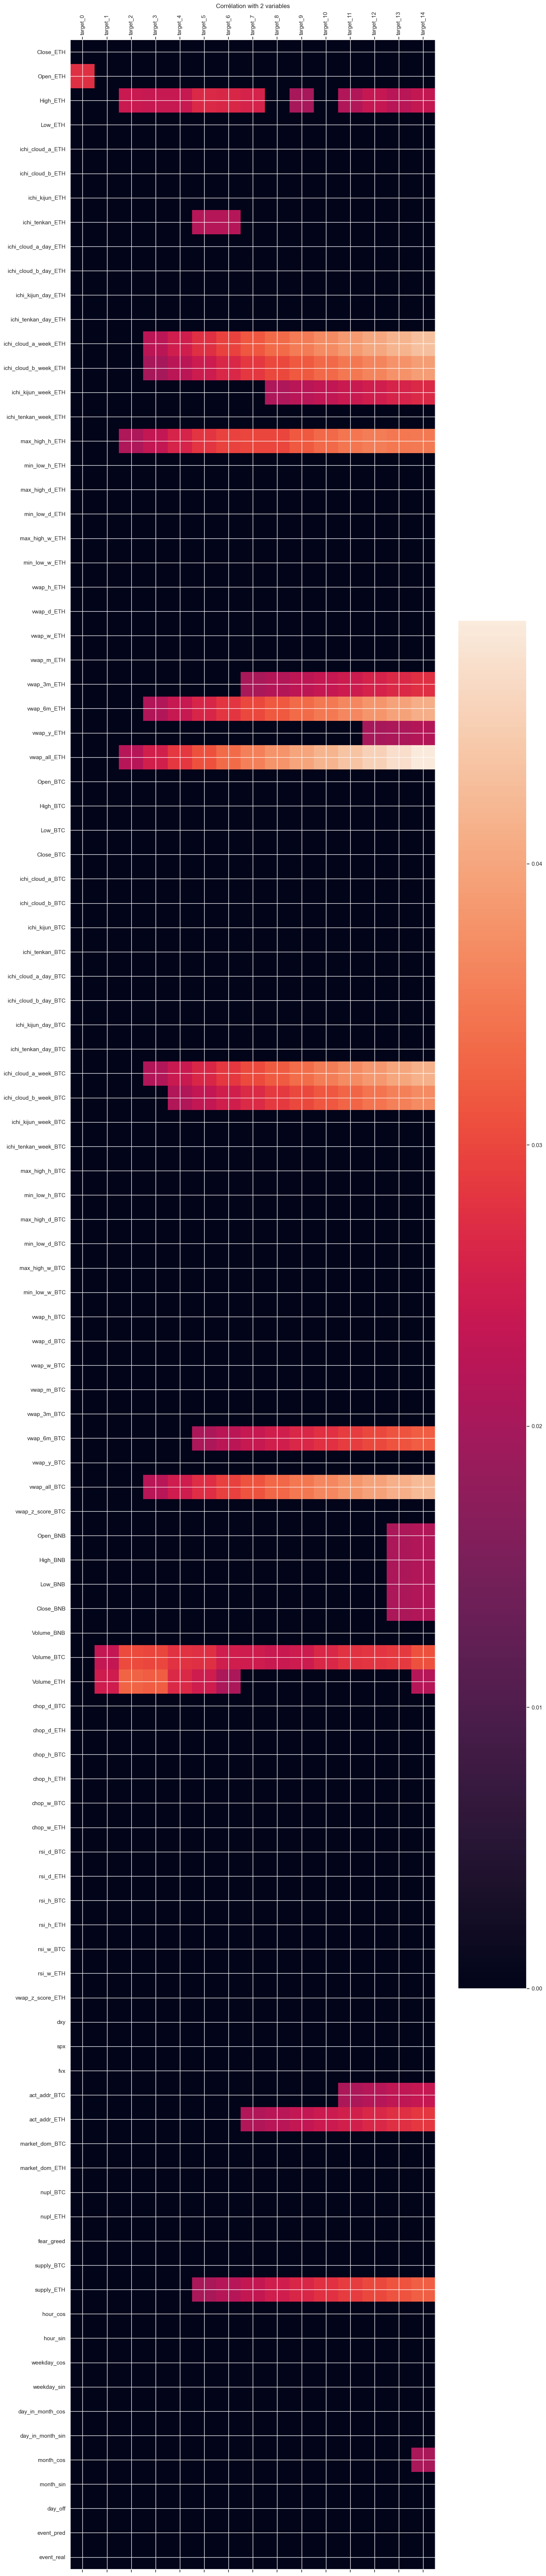

In [62]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [63]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

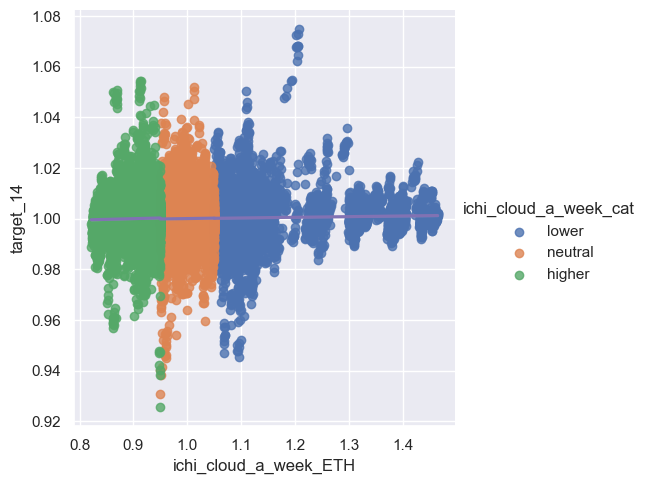

In [64]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

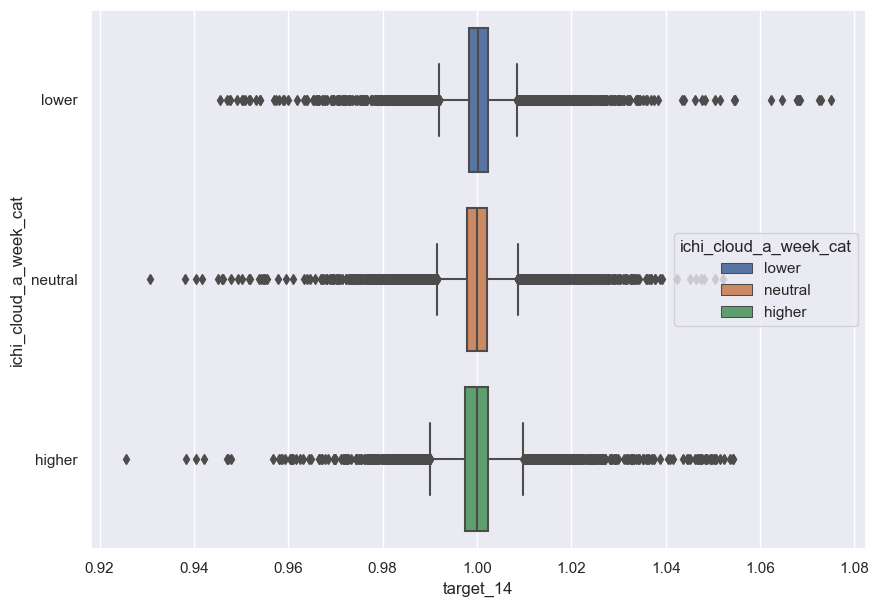

In [65]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [66]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


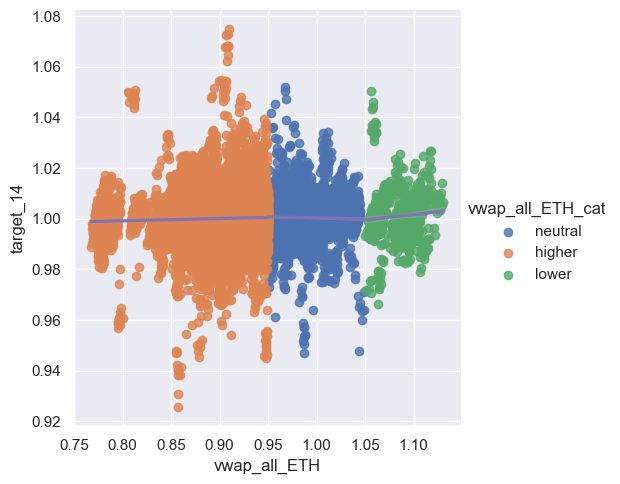

In [67]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

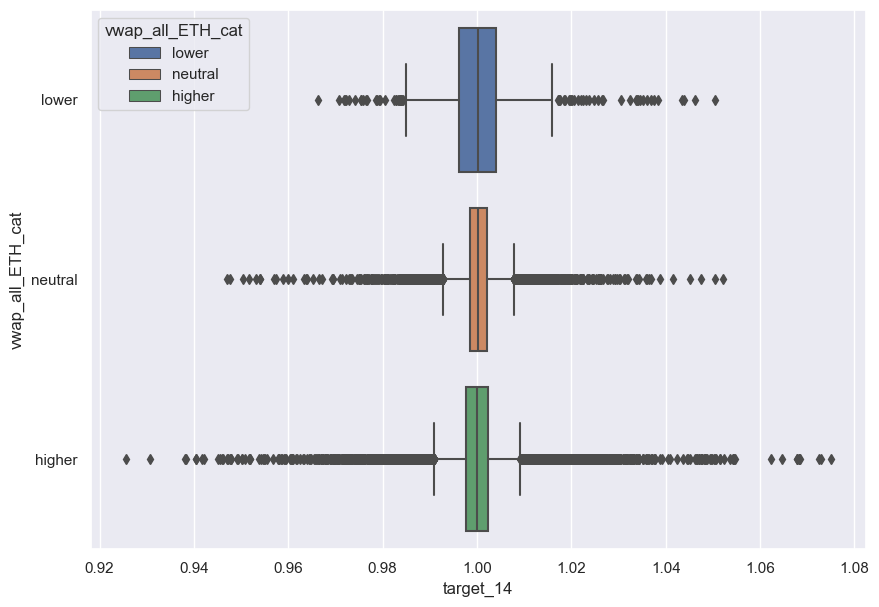

In [68]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

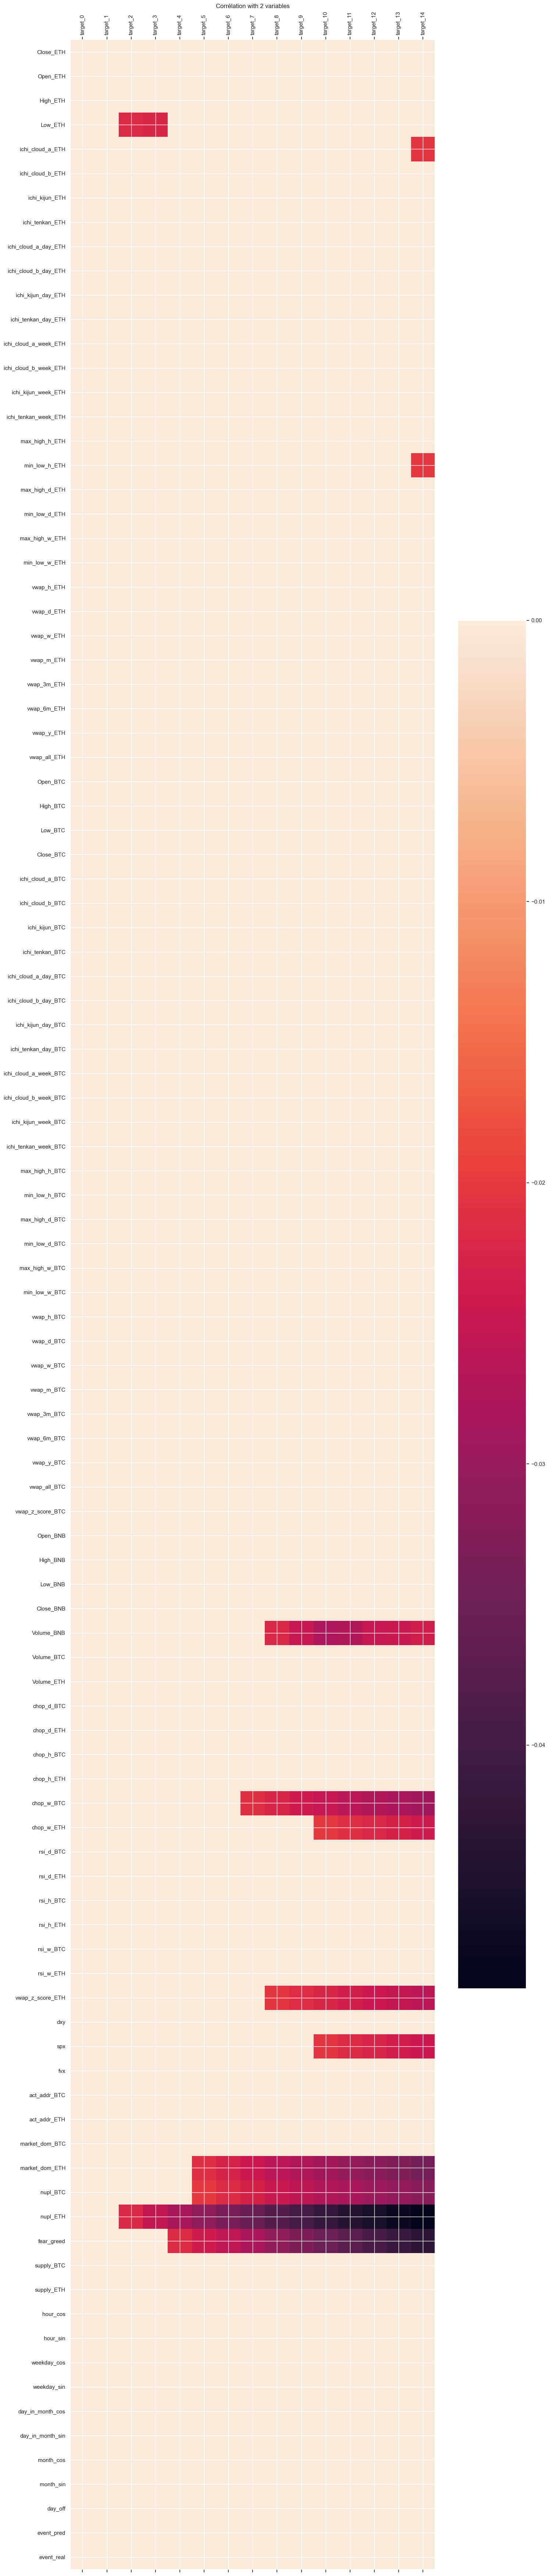

In [69]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

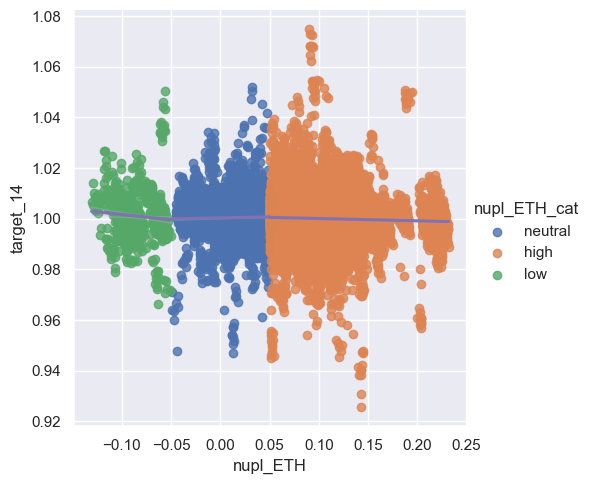

In [70]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

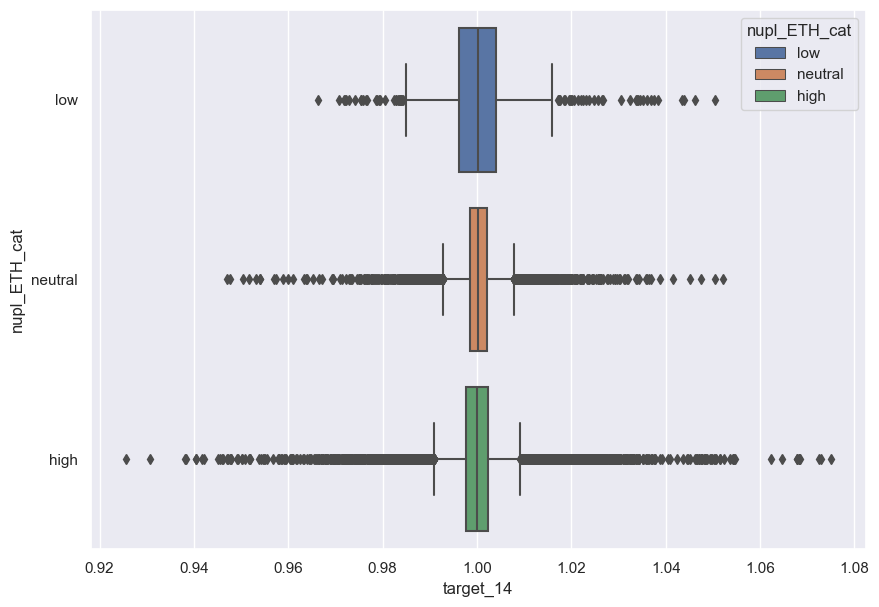

In [71]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [72]:
df["target_14"].describe()

count    52920.000000
mean         1.000158
std          0.005998
min          0.925613
25%          0.997897
50%          1.000049
75%          1.002305
max          1.074927
Name: target_14, dtype: float64

In [73]:
df["target_1"].describe()

count    52920.000000
mean         1.000021
std          0.002202
min          0.967271
25%          0.999170
50%          1.000011
75%          1.000858
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

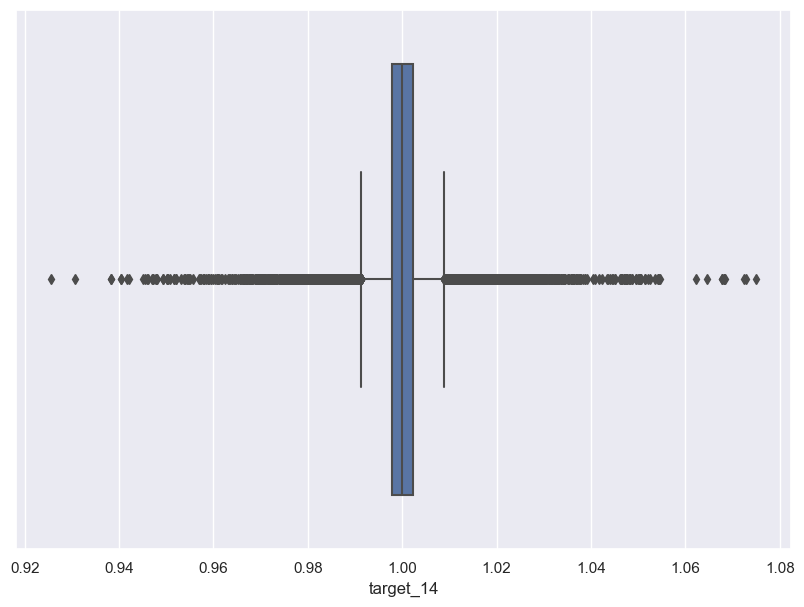

In [74]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [75]:
y_train

array([[0.99979063, 0.99896151, 0.99882751, ..., 0.99942213, 0.99925463,
        0.99937188],
       [0.99917071, 0.99903668, 0.99892778, ..., 0.99946389, 0.99958117,
        0.99954766],
       [0.99986586, 0.99975687, 0.99948021, ..., 1.0004108 , 1.00037726,
        1.00064554],
       ...,
       [0.99919796, 1.00016858, 0.99994381, ..., 0.99866667, 0.9995198 ,
        0.99889145],
       [1.0009714 , 1.00074644, 1.00044991, ..., 1.0003221 , 0.99969324,
        0.99905928],
       [0.99977526, 0.99947902, 0.99856985, ..., 0.99872308, 0.99808973,
        0.997533  ]])

In [76]:
y_train_sca

array([[-0.06617876, -0.25457352, -0.28502116, ..., -0.14990977,
        -0.18796932, -0.16132763],
       [-0.20703854, -0.23749256, -0.26223644, ..., -0.14042039,
        -0.11377312, -0.12138663],
       [-0.04908362, -0.07384804, -0.13671158, ...,  0.0747385 ,
         0.06711868,  0.12807726],
       ...,
       [-0.2008462 ,  0.01970129, -0.03137287, ..., -0.32156693,
        -0.1277173 , -0.27049277],
       [ 0.20212019,  0.15100504,  0.08362597, ...,  0.05458327,
        -0.08830681, -0.2323586 ],
       [-0.06966988, -0.13698355, -0.3435669 , ..., -0.30874948,
        -0.45266147, -0.57916476]])

## Autoencoder

In [77]:
X_train.shape

(52920, 48, 104)

### Model creation

### Training

In [78]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 30 #100 #150 #6 #300
patience = 0 #20 #40 #3 #100
for n_unit_enc in [128]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.05]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            path_jpg = os.path.join(path_data,
                f"output_MSE autoencoder - {plt_name}.jpg")
            if os.path.exists(path_jpg) | (MODE_TRAIN_AE == False):
                print(f"BE CAREFUL ! : {path_jpg} exists or training inactivated => no training done...")
                continue
            print(f"Training: {plt_name} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - {plt_name}",
                saveFolder=path_data)
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")

if MODE_TRAIN_AE:
    print("Save models...")
    autoencoder.save(path_mdl_autoencoder)
    encoder_model.save(path_mdl_encoder)
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())


BE CAREFUL ! : data/output_MSE autoencoder - TS 0.9891 - units 128 - enc_dim 32 - drop 0.05.jpg exists or training inactivated => no training done...
Load models...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 model (Functional)          (None, None, 32)          123424    
                                                                 
 model_1 (Functional)        (None, None, 104)         95848     
                                                                 
Total params: 219,272
Trainable params: 219,272
Non-trainable params: 0
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (Non

### Save model

In [79]:
# TODO select best model


In [80]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [81]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [82]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2023-07-06 08:47:54.368902: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1654/1654 [==============================] - 28s 17ms/step


(52920, 48, 104)

### Results

In [83]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

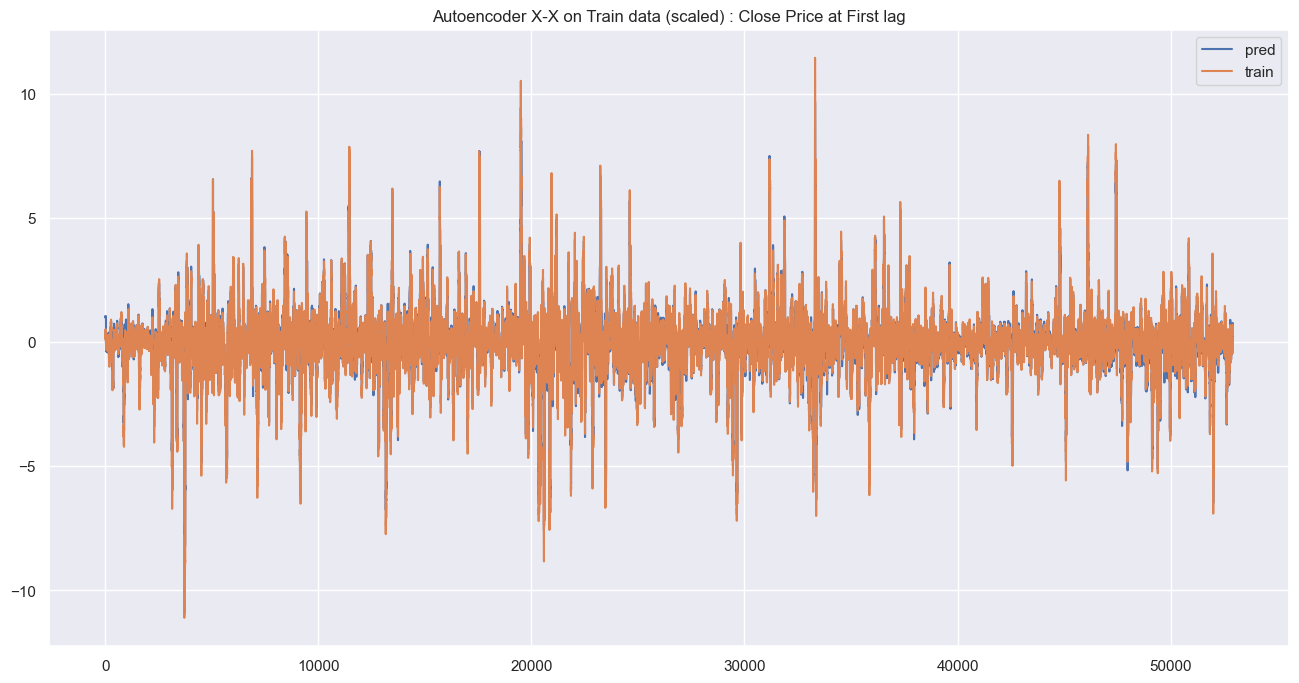

In [84]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE by lags and by features

In [85]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)
df_mae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_train.index))]
df_mae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(52920, 48, 104)
(52920, 48, 104)
(48, 104)
(1, 104)


In [86]:
df_mae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113434  0.151249  0.091693  0.103735          0.121674   
lag_1    0.090401  0.090816  0.080666  0.089666          0.101122   
lag_2    0.066108  0.066535  0.059960  0.069942          0.087064   
lag_3    0.063332  0.060153  0.057657  0.067566          0.082453   
lag_4    0.057125  0.055743  0.052964  0.063140          0.079451   
lag_5    0.054572  0.052475  0.050290  0.060706          0.077431   
lag_6    0.053057  0.051418  0.049135  0.059518          0.076006   
lag_7    0.052245  0.050684  0.048407  0.058845          0.075025   
lag_8    0.051837  0.050353  0.048017  0.058476          0.074208   
lag_9    0.051569  0.050202  0.047796  0.058277          0.073547   
lag_10   0.051348  0.050093  0.047617  0.058098          0.072923   
lag_11   0.051249  0.050025  0.047504  0.058036          0.072359   
lag_12   0.051154  0.049986  0.047399  0.057975          0.071828   
lag_13   0.051061  0.049971  0.047311  0.057936          0.071262   
lag_14   0.050997  0.050002  0.047255  0.057898          0.070686   
lag_15   0.050915  0.049989  0.047201  0.057868          0.070010   
lag_16   0.050828  0.049955  0.047143  0.057810          0.069303   
lag_17   0.050769  0.049933  0.047129  0.057778          0.068557   
lag_18   0.050722  0.049887  0.047064  0.057719          0.067811   
lag_19   0.050659  0.049858  0.047021  0.057685          0.067092   
lag_20   0.050582  0.049832  0.046988  0.057625          0.066430   
lag_21   0.050538  0.049826  0.046976  0.057595          0.065852   
lag_22   0.050450  0.049796  0.046945  0.057496          0.065428   
lag_23   0.050396  0.049726  0.046893  0.057437          0.065087   
lag_24   0.050365  0.049704  0.046864  0.057384          0.064858   
lag_25   0.050300  0.049690  0.046835  0.057338          0.064725   
lag_26   0.050242  0.049688  0.046814  0.057328          0.064705   
lag_27   0.050215  0.049673  0.046805  0.057303          0.064680   
lag_28   0.050137  0.049649  0.046774  0.057275          0.064618   
lag_29   0.050093  0.049582  0.046732  0.057234          0.064562   
lag_30   0.050039  0.049558  0.046736  0.057212          0.064538   
lag_31   0.049951  0.049549  0.046702  0.057175          0.064503   
lag_32   0.049908  0.049510  0.046681  0.057133          0.064494   
lag_33   0.049879  0.049457  0.046640  0.057098          0.064477   
lag_34   0.049822  0.049432  0.046622  0.057059          0.064472   
lag_35   0.049807  0.049435  0.046605  0.057048          0.064478   
lag_36   0.049738  0.049426  0.046581  0.057025          0.064485   
lag_37   0.049669  0.049398  0.046551  0.056996          0.064496   
lag_38   0.049595  0.049364  0.046487  0.056914          0.064492   
lag_39   0.049533  0.049330  0.046424  0.056856          0.064480   
lag_40   0.049485  0.049319  0.046393  0.056820          0.064481   
lag_41   0.049393  0.049295  0.046378  0.056786          0.064475   
lag_42   0.049343  0.049252  0.046356  0.056755          0.064442   
lag_43   0.049303  0.049244  0.046366  0.056762          0.064451   
lag_44   0.049244  0.049191  0.046306  0.056738          0.064447   
lag_45   0.049150  0.049166  0.046249  0.056675          0.064420   
lag_46   0.049080  0.049137  0.046181  0.056628          0.064407   
lag_47   0.048993  0.049143  0.046146  0.056580          0.064378   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119087        0.126350         0.115732   
lag_1           0.101175        0.116169         0.108024   
lag_2           0.086155        0.100667         0.089451   
lag_3           0.082471        0.096828         0.085258   
lag_4           0.079232        0.091238         0.077996   
lag_5           0.077790        0.086862         0.071660   
lag_6           0.076789        0.083066         0.066502   
lag_7           0.075918        0.079841         0.062549   
lag_8           0.075105        0.076701         0.059711   
lag_9           

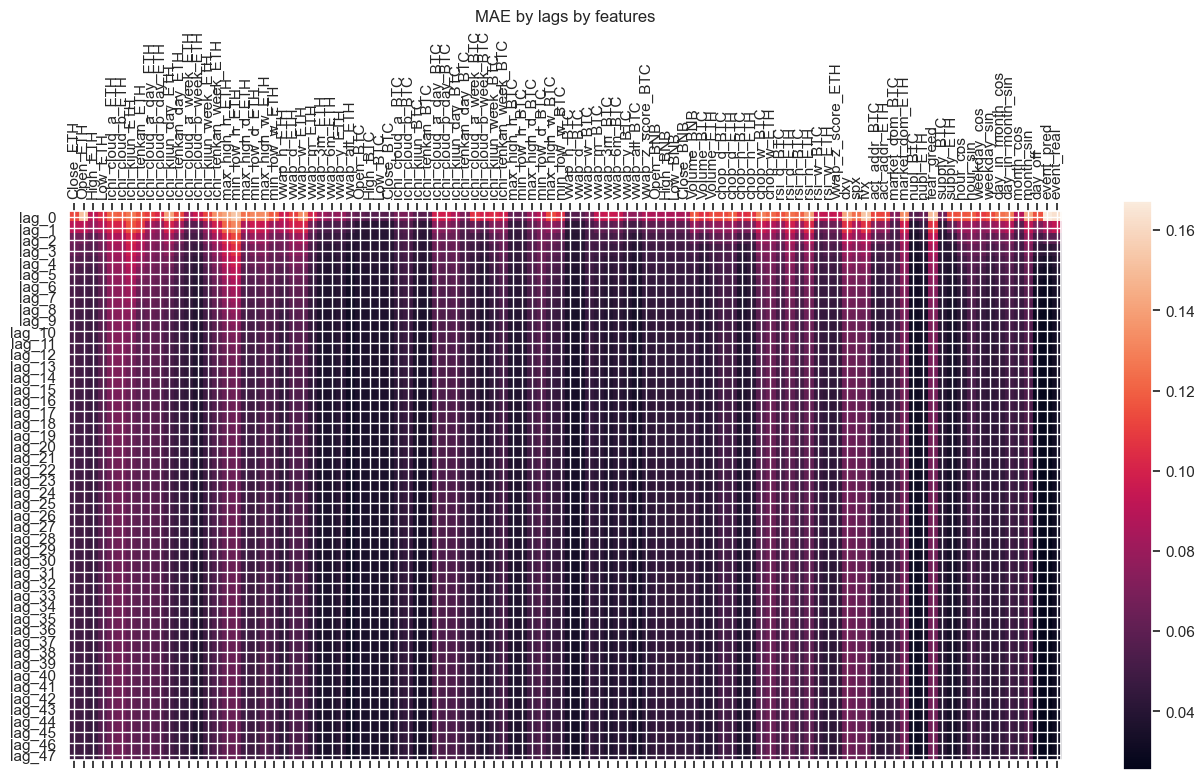

In [87]:
plot_corr(df_mae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

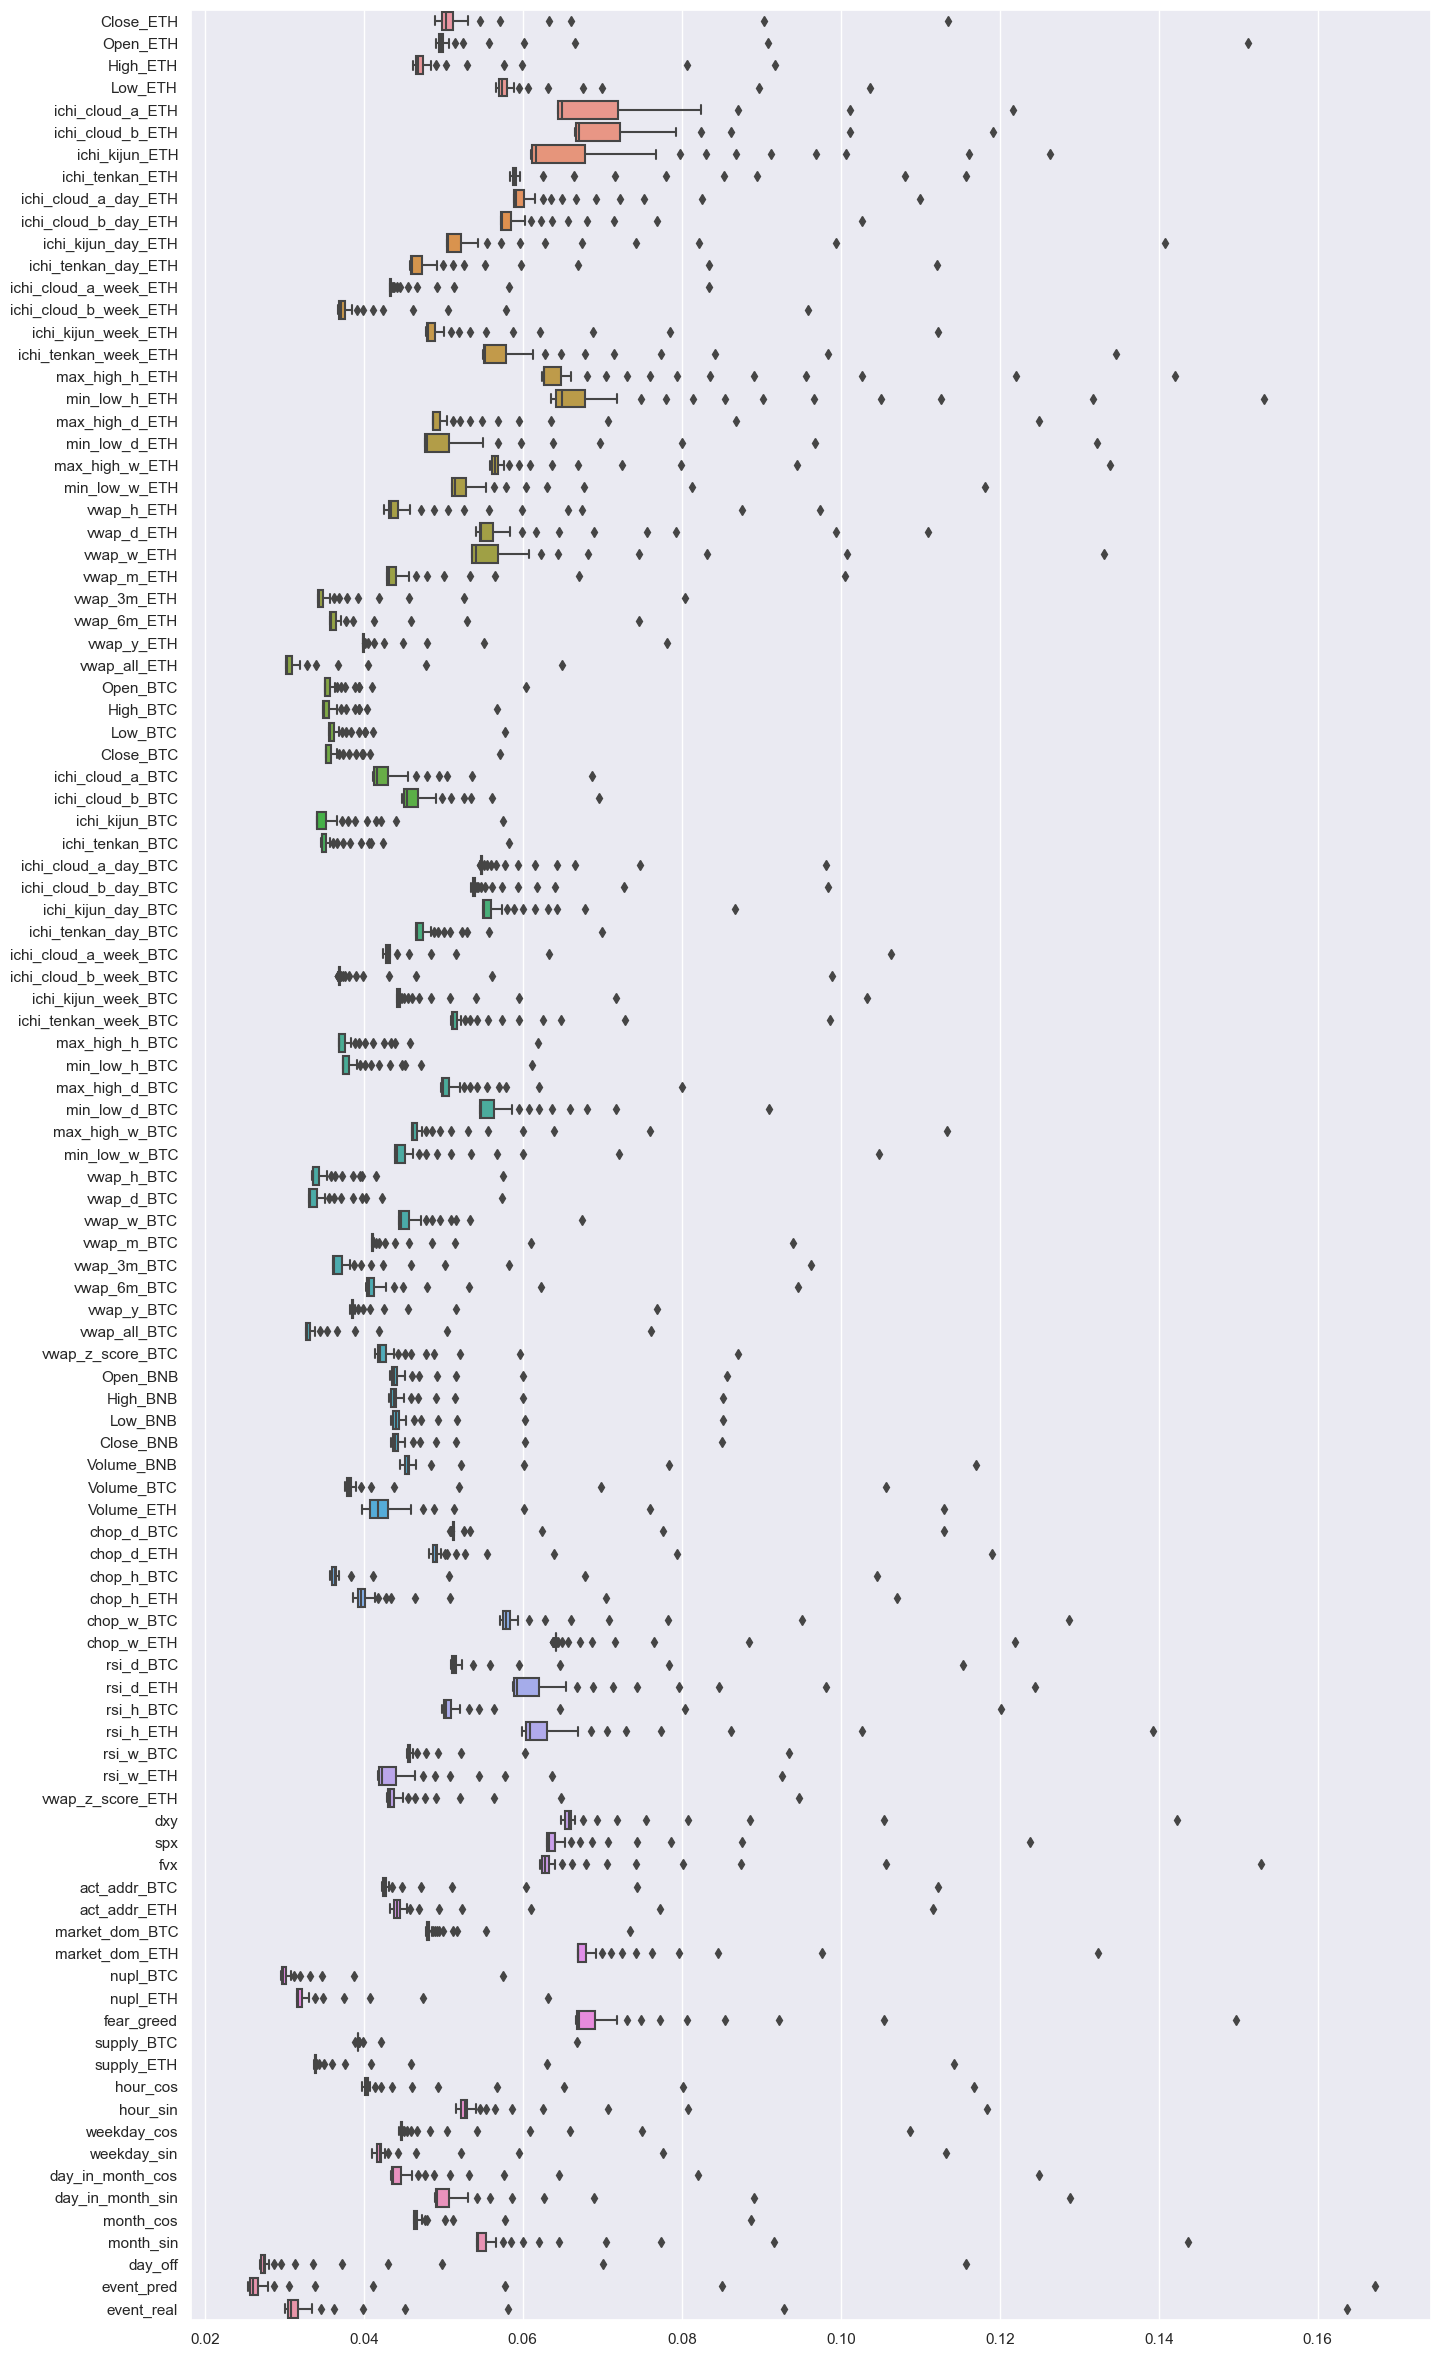

In [88]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_train, orient="h")

In [89]:
df_mae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.053305  0.053431  0.049255  0.059728          0.070025   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.071354        0.068868         0.063179              0.062028   

   ichi_cloud_b_day_ETH  ...  hour_sin  weekday_cos  weekday_sin  \
0              0.059933  ...   0.05536      0.04788     0.044814   

   day_in_month_cos  day_in_month_sin  month_cos  month_sin   day_off  \
0          0.047595          0.053174   0.047828    0.05859  0.031334   

   event_pred  event_real  
0     0.03155    0.036197  

[1 rows x 104 columns]

Text(0.5, 1.0, 'MAE per feature')

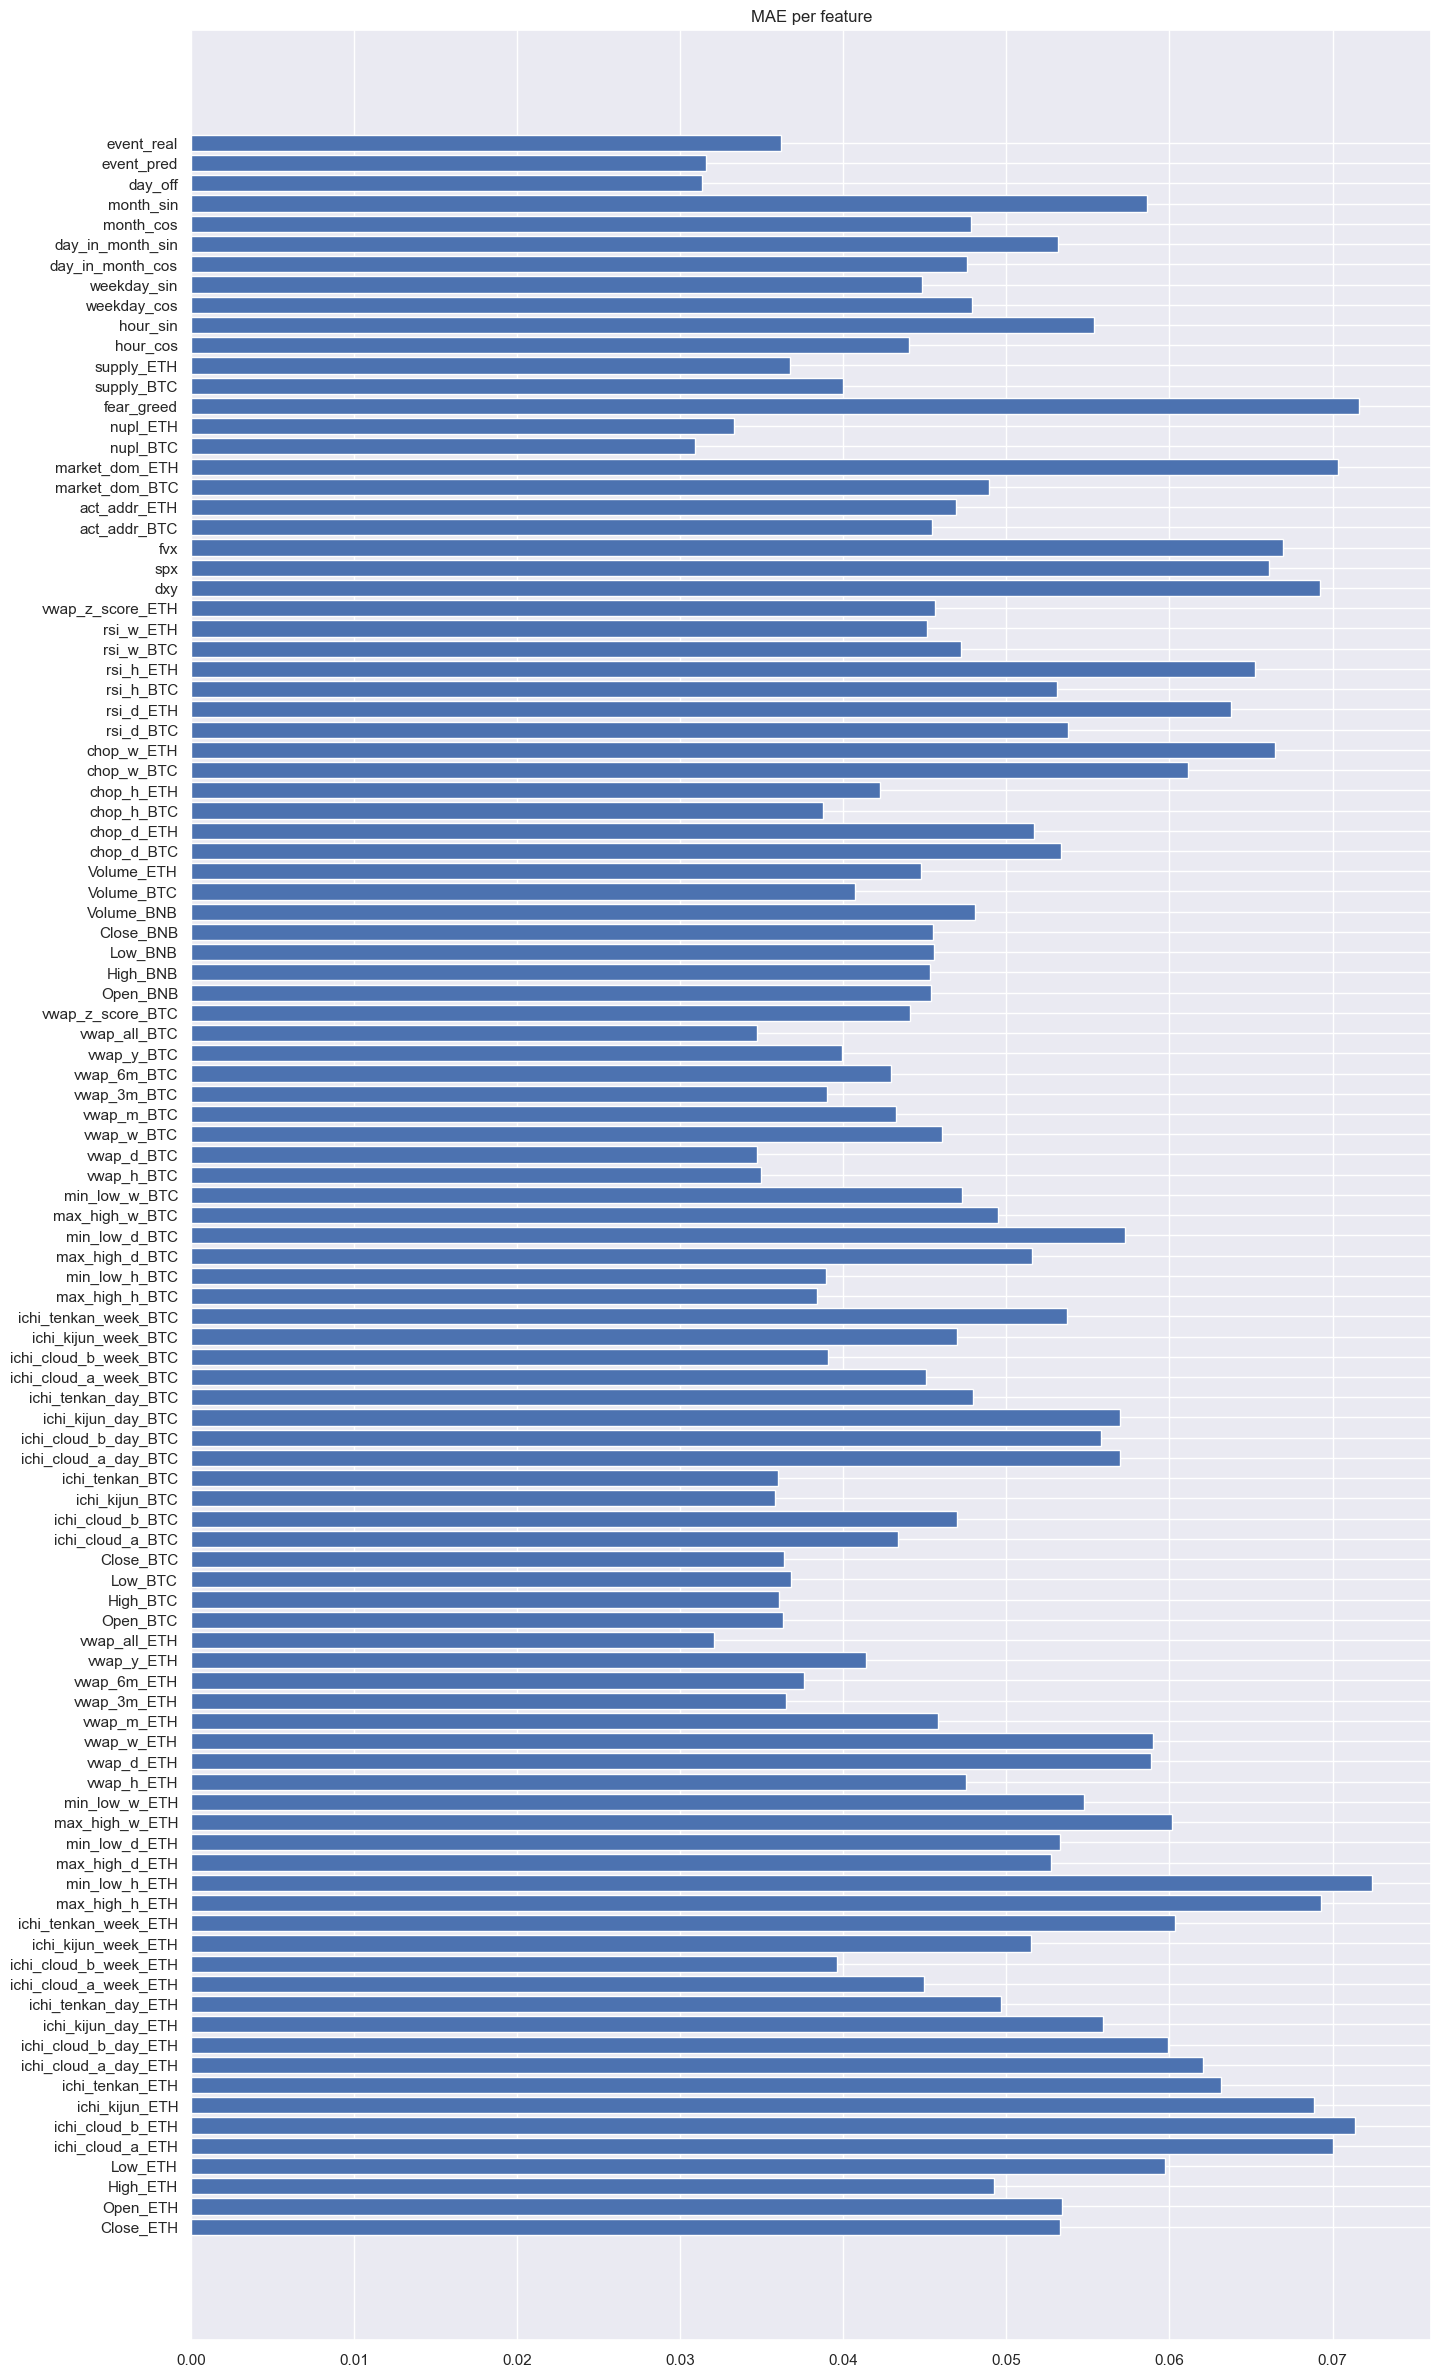

In [90]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_train_feat.columns, df_mae_train_feat.values[0])
plt.title("MAE per feature")

In [91]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(52920,)
(52920,)
[1196.32 1195.38 1194.55 ... 1963.3  1964.55 1964.21]
[1196.32 1195.38 1194.55]


In [92]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.0011708 , 1.0010699 , 1.0010018 , ..., 0.99948925, 1.0000757 ,
       0.9998698 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1963.3  1964.55 1964.21]
[1203.05614209 1202.81506998 1201.92451458 ... 1964.15800434 1964.90081092
 1965.50578374]


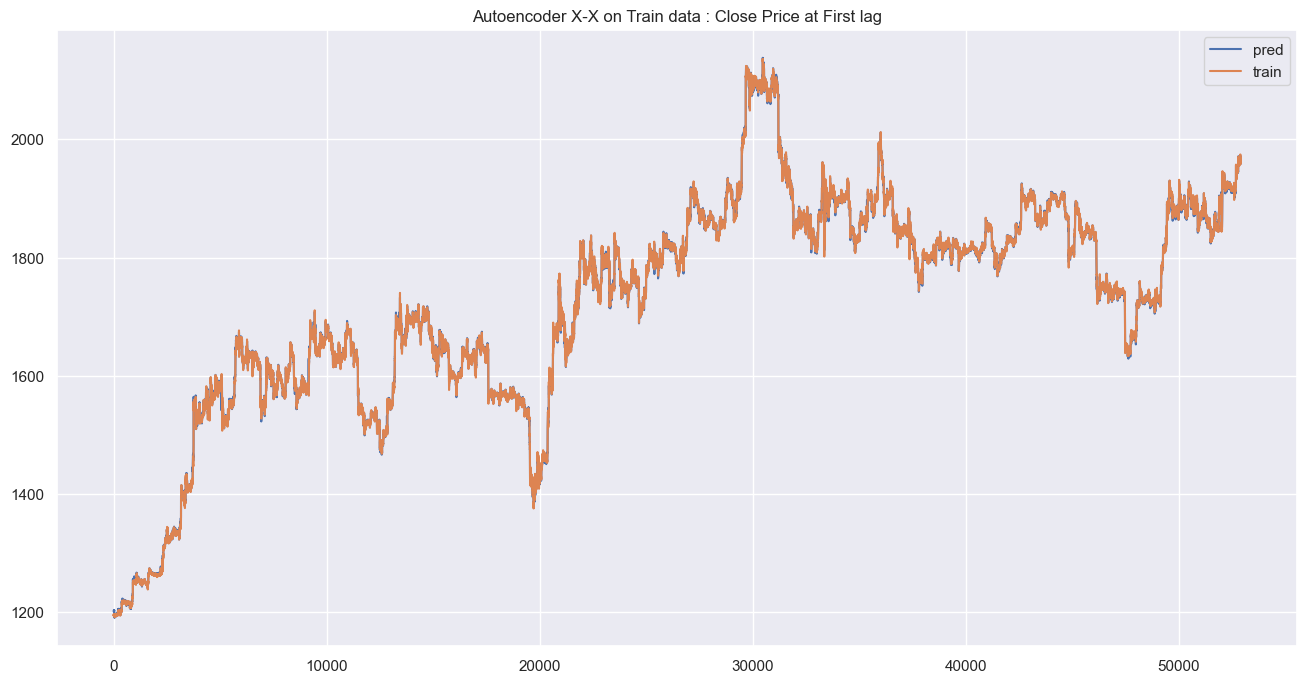

In [93]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [94]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

17/17 [==============================] - 0s 24ms/step


(520, 48, 104)

In [95]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-03 23:10:00'

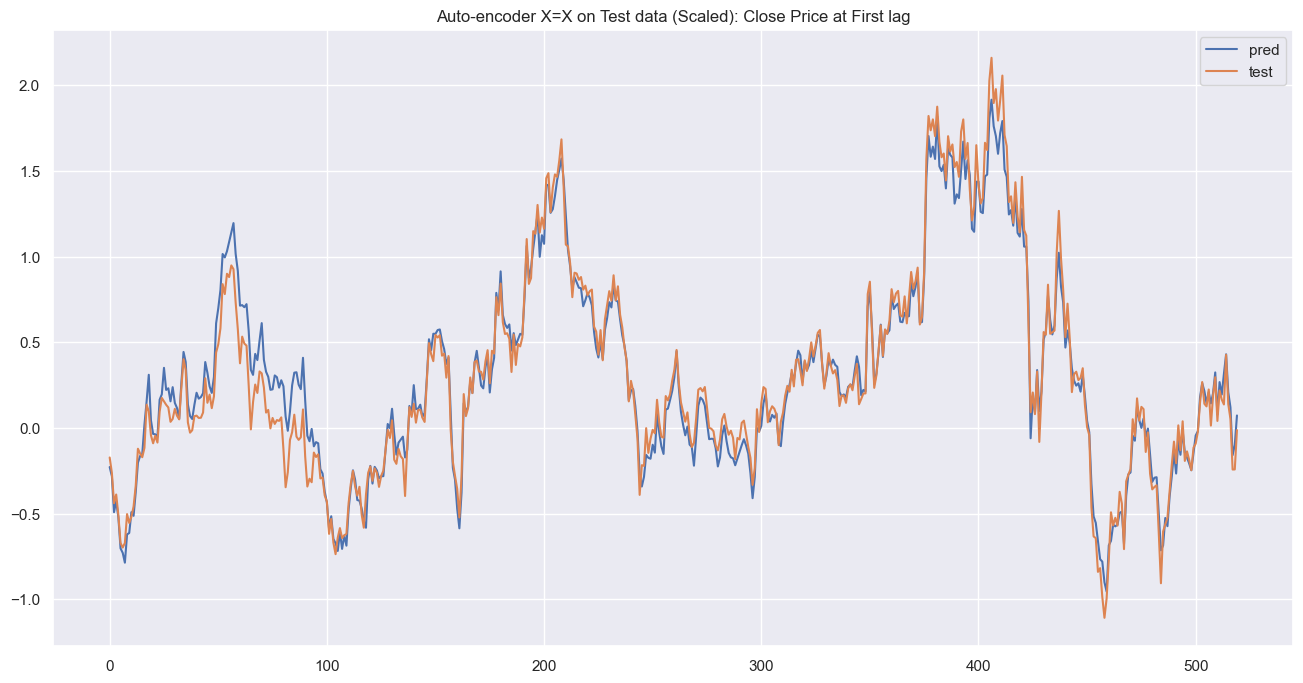

In [96]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [97]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1952.86 1952.5  1953.39 1954.25 1954.53 1954.92 1953.9  1954.31 1955.54]
X test pred :  [1952.0408024  1952.19592749 1952.61897297 1953.69286634 1954.34488765
 1954.45953605 1953.44620618 1952.60999873 1953.79151997]


[1952.86 1952.5  1953.39 1954.25 1954.53 1954.92 1953.9  1954.31 1955.54
 1954.8  1954.02 1954.   1953.85 1954.36 1955.49 1955.33 1955.81 1956.76
 1952.74 1951.86 1951.61 1952.99 1953.39 1953.4  1956.22 1955.54 1956.
 1954.81 1954.76 1954.19 1953.98 1953.82 1954.24 1955.2  1954.96 1955.23
 1954.88 1953.93 1955.06 1956.18 1955.44 1955.4  1955.77 1955.22 1956.6
 1955.3  1955.48 1955.75 1956.7  1960.22 1960.33 1962.41 1965.2  1964.57
 1964.58 1963.32 1963.34 1962.02 1961.12 1959.15 1956.5  1958.04 1958.2
 1957.88 1955.12 1951.68 1952.85 1953.28 1954.01 1955.   1952.36 1954.
 1953.61 1954.37 1953.41 1954.59 1953.77 1952.7  1953.13 1953.86 1952.12
 1949.43 1950.64 1954.76 1954.69 1955.61 1955.53 1954.74 1954.9  1955.25
 1954.25 1952.7  1953.5  1952.98 1954.41 1954.35 1954.11 1953.51 1954.21
 1953.23 1953.45 1951.73 1950.76 1949.79 1948.8  1950.74 1951.06 1951.32
 1950.58 1951.33 1951.19 1951.83 1952.16 1951.   1949.92 1951.37 1950.52
 1948.05 1950.89 1952.65 1953.18 1953.8  1954.09 1953.78 

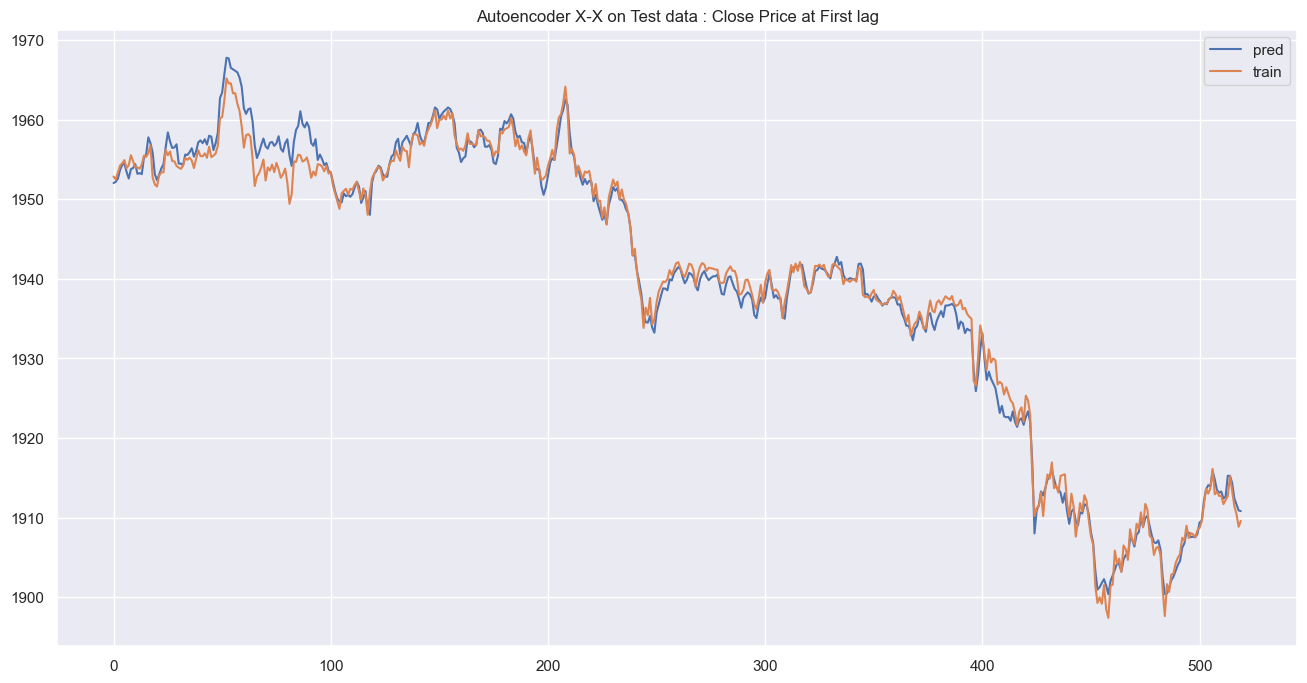

In [98]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [99]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(520, 48, 104)
(520, 48, 104)
(48, 104)
(1, 104)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113434  0.151249  0.091693  0.103735          0.121674   
lag_1    0.090401  0.090816  0.080666  0.089666          0.101122   
lag_2    0.066108  0.066535  0.059960  0.069942          0.087064   
lag_3    0.063332  0.060153  0.057657  0.067566          0.082453   
lag_4    0.057125  0.055743  0.052964  0.063140          0.079451   
...           ...       ...       ...       ...               ...   
lag_43   0.039777  0.050688  0.032730  0.057698          0.079919   
lag_44   0.039763  0.050594  0.032747  0.057716          0.079973   
lag_45   0.039397  0.050688  0.032631  0.057567          0.080099   
lag_46   0.039267  0.050490  0.032812  0.057402          0.080223   
lag_47   0.039206  0.050296  0.032825  0.057348          0.080444   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119087        0.126350         0.115732   
lag_1           0.101175        0.116169         0.108024   
lag_2           0.086155        0.100667         0.089451   
lag_3           0.082471        0.096828         0.085258   
lag_4           0.079232        0.091238         0.077996   
...                  ...             ...              ...   
lag_43          0.074110        0.059055         0.047361   
lag_44          0.073990        0.059273         0.047429   
lag_45          0.073774        0.059347         0.047367   
lag_46          0.073556        0.059257         0.047377   
lag_47          0.073354        0.059268         0.047414   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109939              0.102708  ...     0.108755   
lag_1               0.082542              0.076844  ...     0.074938   
lag_2               0.075199              0.071520  ...     0.065953   
lag_3               0.072212              0.068125  ...     0.060854   
lag_4               0.069180              0.065636  ...     0.054266   
...                      ...                   ...  ...          ...   
lag_43              0.172316              0.195087  ...     0.090071   
lag_44              0.172257              0.195295  ...     0.089827   
lag_45              0.172187              0.195497  ...     0.089649   
lag_46              0.172051              0.195743  ...     0.089491   
lag_47              0.171935              0.196006  ...     0.089349   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113210          0.124874          0.128868   0.088762   0.143710   
lag_1      0.077614          0.082100          0.089069   0.057780   0.091601   
lag_2      0.059551          0.064549          0.068941   0.051208   0.077381   
lag_3      0.052213          0.057665          0.062653   0.050253   0.070508   
lag_4      0.046621          0.053282          0.058598   0.047994   0.064513   
...             ...               ...               ...        ...        ...   
lag_43     0.096155          0.241331          0.118310   0.107710   0.556969   
lag_44     0.096230          0.241290          0.118398   0.107609   0.557364   
lag_45     0.096240          0.241205          0.118477   0.107455   0.557815   
lag_46     0.096217          0.241143          0.118548   0.107369   0.558227   
lag_47     0.096449          0.241151          0.118667   0.107305   0.558678   

         day_off  event_pred  event_real  dataset  
lag_0   0.115815    0.167194    0.163616    TRAIN  
lag_1   0.070098    0.085044    0.092829    TRAIN  
lag_2   0.049851    0.057721    0.058107    TRAIN  
lag_3   0.043011    0.041123    0.045188    TRAIN  
lag_4   0.037243    0.033904    0.039873    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.174494    0.039183    0.043582     TEST  
lag_44  0.174534    0.039040    0.043650     TEST  
lag_45  0.174410    0.039018    0.043656     TEST  
lag_46  0.174434    0.038934    0.043756     TEST  
lag_47  0.174247    0.038967    0.04

In [100]:
df_mae_ae_comp

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.113434  0.151249  0.091693  0.103735          0.121674   
lag_1    0.090401  0.090816  0.080666  0.089666          0.101122   
lag_2    0.066108  0.066535  0.059960  0.069942          0.087064   
lag_3    0.063332  0.060153  0.057657  0.067566          0.082453   
lag_4    0.057125  0.055743  0.052964  0.063140          0.079451   
...           ...       ...       ...       ...               ...   
lag_43   0.039777  0.050688  0.032730  0.057698          0.079919   
lag_44   0.039763  0.050594  0.032747  0.057716          0.079973   
lag_45   0.039397  0.050688  0.032631  0.057567          0.080099   
lag_46   0.039267  0.050490  0.032812  0.057402          0.080223   
lag_47   0.039206  0.050296  0.032825  0.057348          0.080444   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.119087        0.126350         0.115732   
lag_1           0.101175        0.116169         0.108024   
lag_2           0.086155        0.100667         0.089451   
lag_3           0.082471        0.096828         0.085258   
lag_4           0.079232        0.091238         0.077996   
...                  ...             ...              ...   
lag_43          0.074110        0.059055         0.047361   
lag_44          0.073990        0.059273         0.047429   
lag_45          0.073774        0.059347         0.047367   
lag_46          0.073556        0.059257         0.047377   
lag_47          0.073354        0.059268         0.047414   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  weekday_cos  \
lag_0               0.109939              0.102708  ...     0.108755   
lag_1               0.082542              0.076844  ...     0.074938   
lag_2               0.075199              0.071520  ...     0.065953   
lag_3               0.072212              0.068125  ...     0.060854   
lag_4               0.069180              0.065636  ...     0.054266   
...                      ...                   ...  ...          ...   
lag_43              0.172316              0.195087  ...     0.090071   
lag_44              0.172257              0.195295  ...     0.089827   
lag_45              0.172187              0.195497  ...     0.089649   
lag_46              0.172051              0.195743  ...     0.089491   
lag_47              0.171935              0.196006  ...     0.089349   

        weekday_sin  day_in_month_cos  day_in_month_sin  month_cos  month_sin  \
lag_0      0.113210          0.124874          0.128868   0.088762   0.143710   
lag_1      0.077614          0.082100          0.089069   0.057780   0.091601   
lag_2      0.059551          0.064549          0.068941   0.051208   0.077381   
lag_3      0.052213          0.057665          0.062653   0.050253   0.070508   
lag_4      0.046621          0.053282          0.058598   0.047994   0.064513   
...             ...               ...               ...        ...        ...   
lag_43     0.096155          0.241331          0.118310   0.107710   0.556969   
lag_44     0.096230          0.241290          0.118398   0.107609   0.557364   
lag_45     0.096240          0.241205          0.118477   0.107455   0.557815   
lag_46     0.096217          0.241143          0.118548   0.107369   0.558227   
lag_47     0.096449          0.241151          0.118667   0.107305   0.558678   

         day_off  event_pred  event_real  dataset  
lag_0   0.115815    0.167194    0.163616    TRAIN  
lag_1   0.070098    0.085044    0.092829    TRAIN  
lag_2   0.049851    0.057721    0.058107    TRAIN  
lag_3   0.043011    0.041123    0.045188    TRAIN  
lag_4   0.037243    0.033904    0.039873    TRAIN  
...          ...         ...         ...      ...  
lag_43  0.174494    0.039183    0.043582     TEST  
lag_44  0.174534    0.039040    0.043650     TEST  
lag_45  0.174410    0.039018    0.043656     TEST  
lag_46  0.174434    0.038934    0.043756     TEST  
lag_47  0.174247    0.038967    0.04

In [101]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0      TRAIN   Close_ETH  0.113434
1      TRAIN   Close_ETH  0.090401
2      TRAIN   Close_ETH  0.066108
3      TRAIN   Close_ETH  0.063332
4      TRAIN   Close_ETH  0.057125
...      ...         ...       ...
9979    TEST  event_real  0.043582
9980    TEST  event_real  0.043650
9981    TEST  event_real  0.043656
9982    TEST  event_real  0.043756
9983    TEST  event_real  0.043738

[9984 rows x 3 columns]

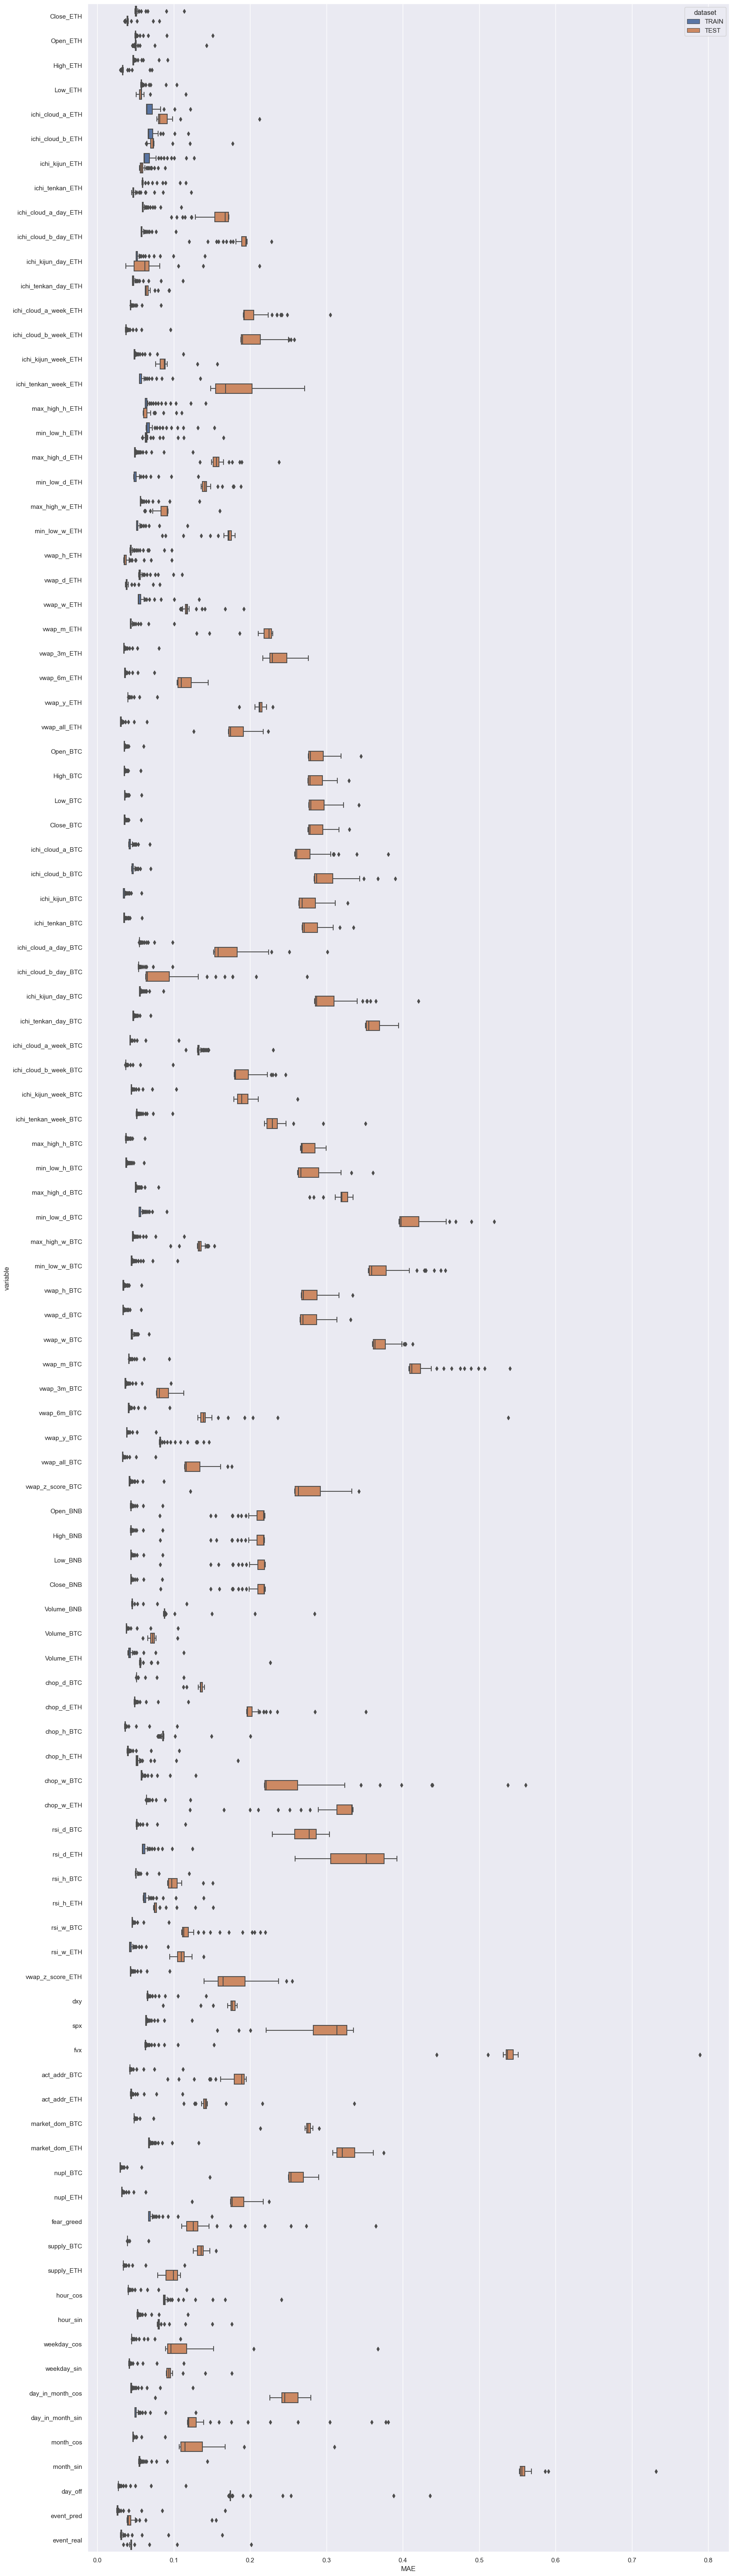

In [102]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

In [103]:
encoder_model.layers[3].get_weights()

[array([[ 0.842958  ,  0.5063907 ,  0.45411888, ...,  0.01483321,
          1.5882727 , -0.36009565],
        [-0.11249828,  0.11688974,  0.3335934 , ...,  0.04197494,
          0.25292554, -0.02393412],
        [ 0.04484627,  0.10462276,  0.05259531, ...,  0.12596804,
          0.16488573,  0.18017781],
        ...,
        [ 0.20715614,  0.02664023, -0.27958483, ...,  0.03626311,
         -0.06333295, -0.3152785 ],
        [ 0.02469139, -0.06407242,  0.2248977 , ..., -0.17936683,
         -0.03836902, -0.2845099 ],
        [-0.3445294 , -0.33057272, -0.27452046, ...,  0.15807603,
          0.34676582,  0.1296677 ]], dtype=float32),
 array([-4.6747448e-03,  2.6166180e-01, -1.1138902e-01,  1.3655911e-01,
        -3.0430162e-02,  2.7835512e-01, -1.2995267e-01,  1.8006296e-01,
         3.4296926e-02,  1.7117482e-01,  6.6168085e-02, -2.8049654e-01,
         3.2343674e-02, -4.1865915e-02,  3.6488373e-02,  3.2718420e-02,
        -2.9019001e-01,  1.9895509e-04,  9.0200752e-02,  1.2685241e-01

## Prediction Models

### LSTM all features

In [104]:
X_train_sca.shape

(52920, 48, 104)

In [105]:
X_train_sca.shape[-1]

104

In [106]:
X_train_sca.shape[-2:]

(48, 104)

In [107]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [108]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [109]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1654/1654 [==============================] - 15s 9ms/step


(52920, 48, 32)

In [110]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

 1/17 [>.............................] - ETA: 0s

17/17 [==============================] - 0s 13ms/step


(520, 48, 32)

In [111]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [112]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [113]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [114]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((52920, 48, 36), (520, 48, 36))

#### Correlations

In [115]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



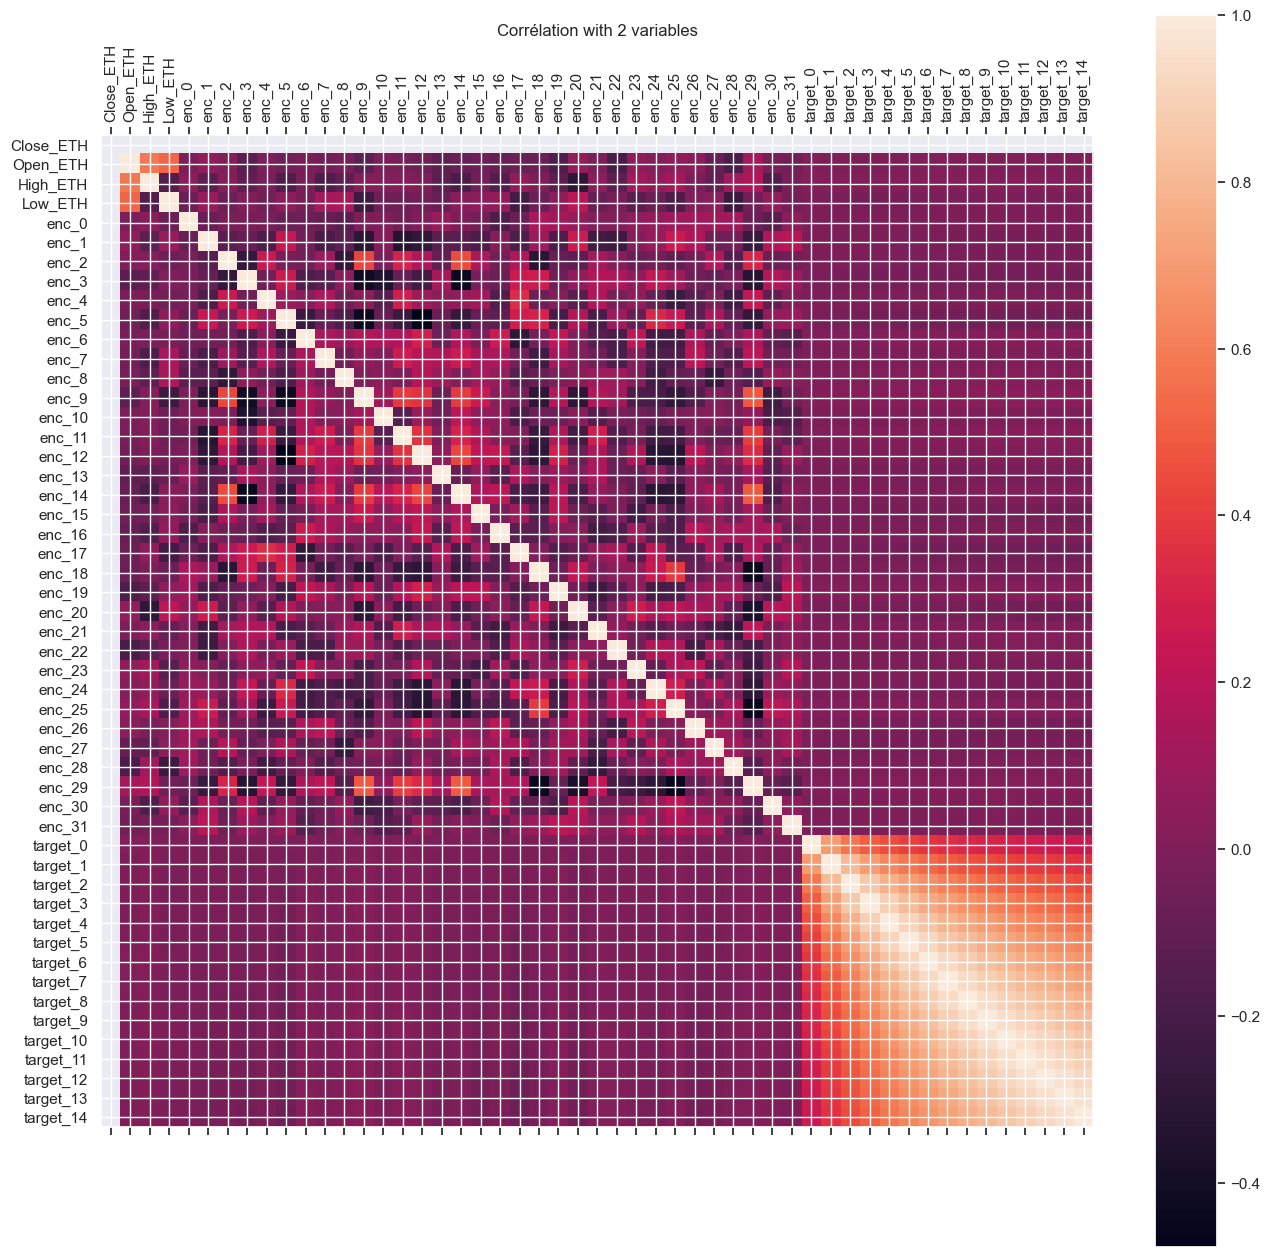

In [116]:
fig = plot_corr(corr_matrix_min)

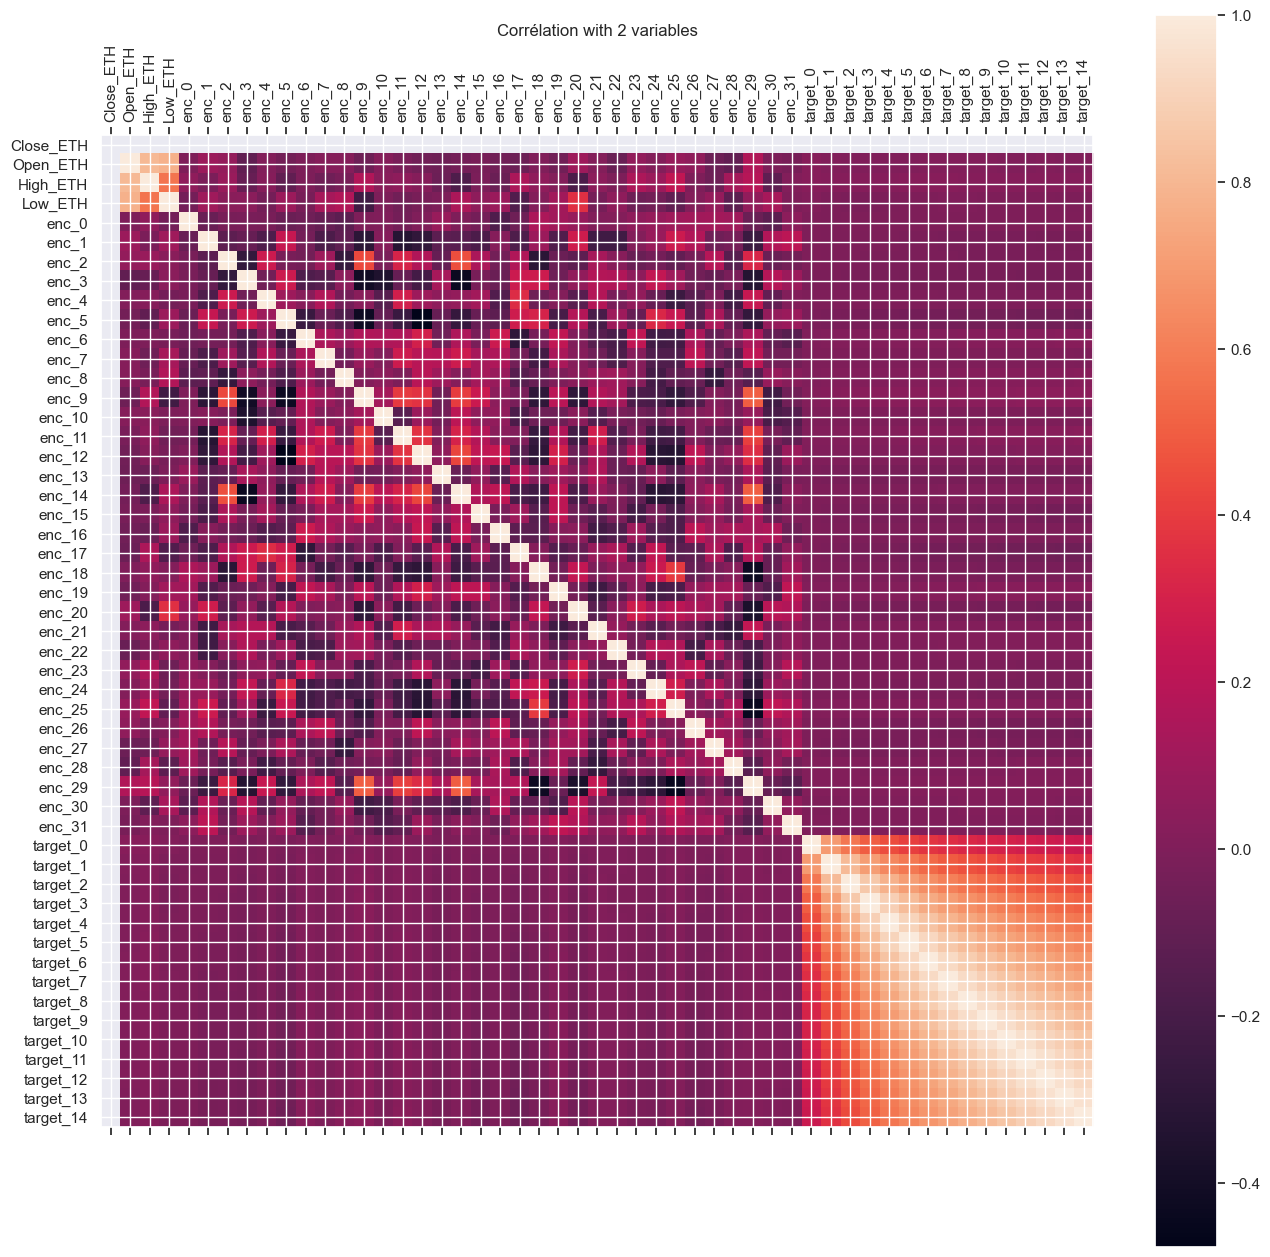

In [117]:
fig = plot_corr(corr_matrix_max) 

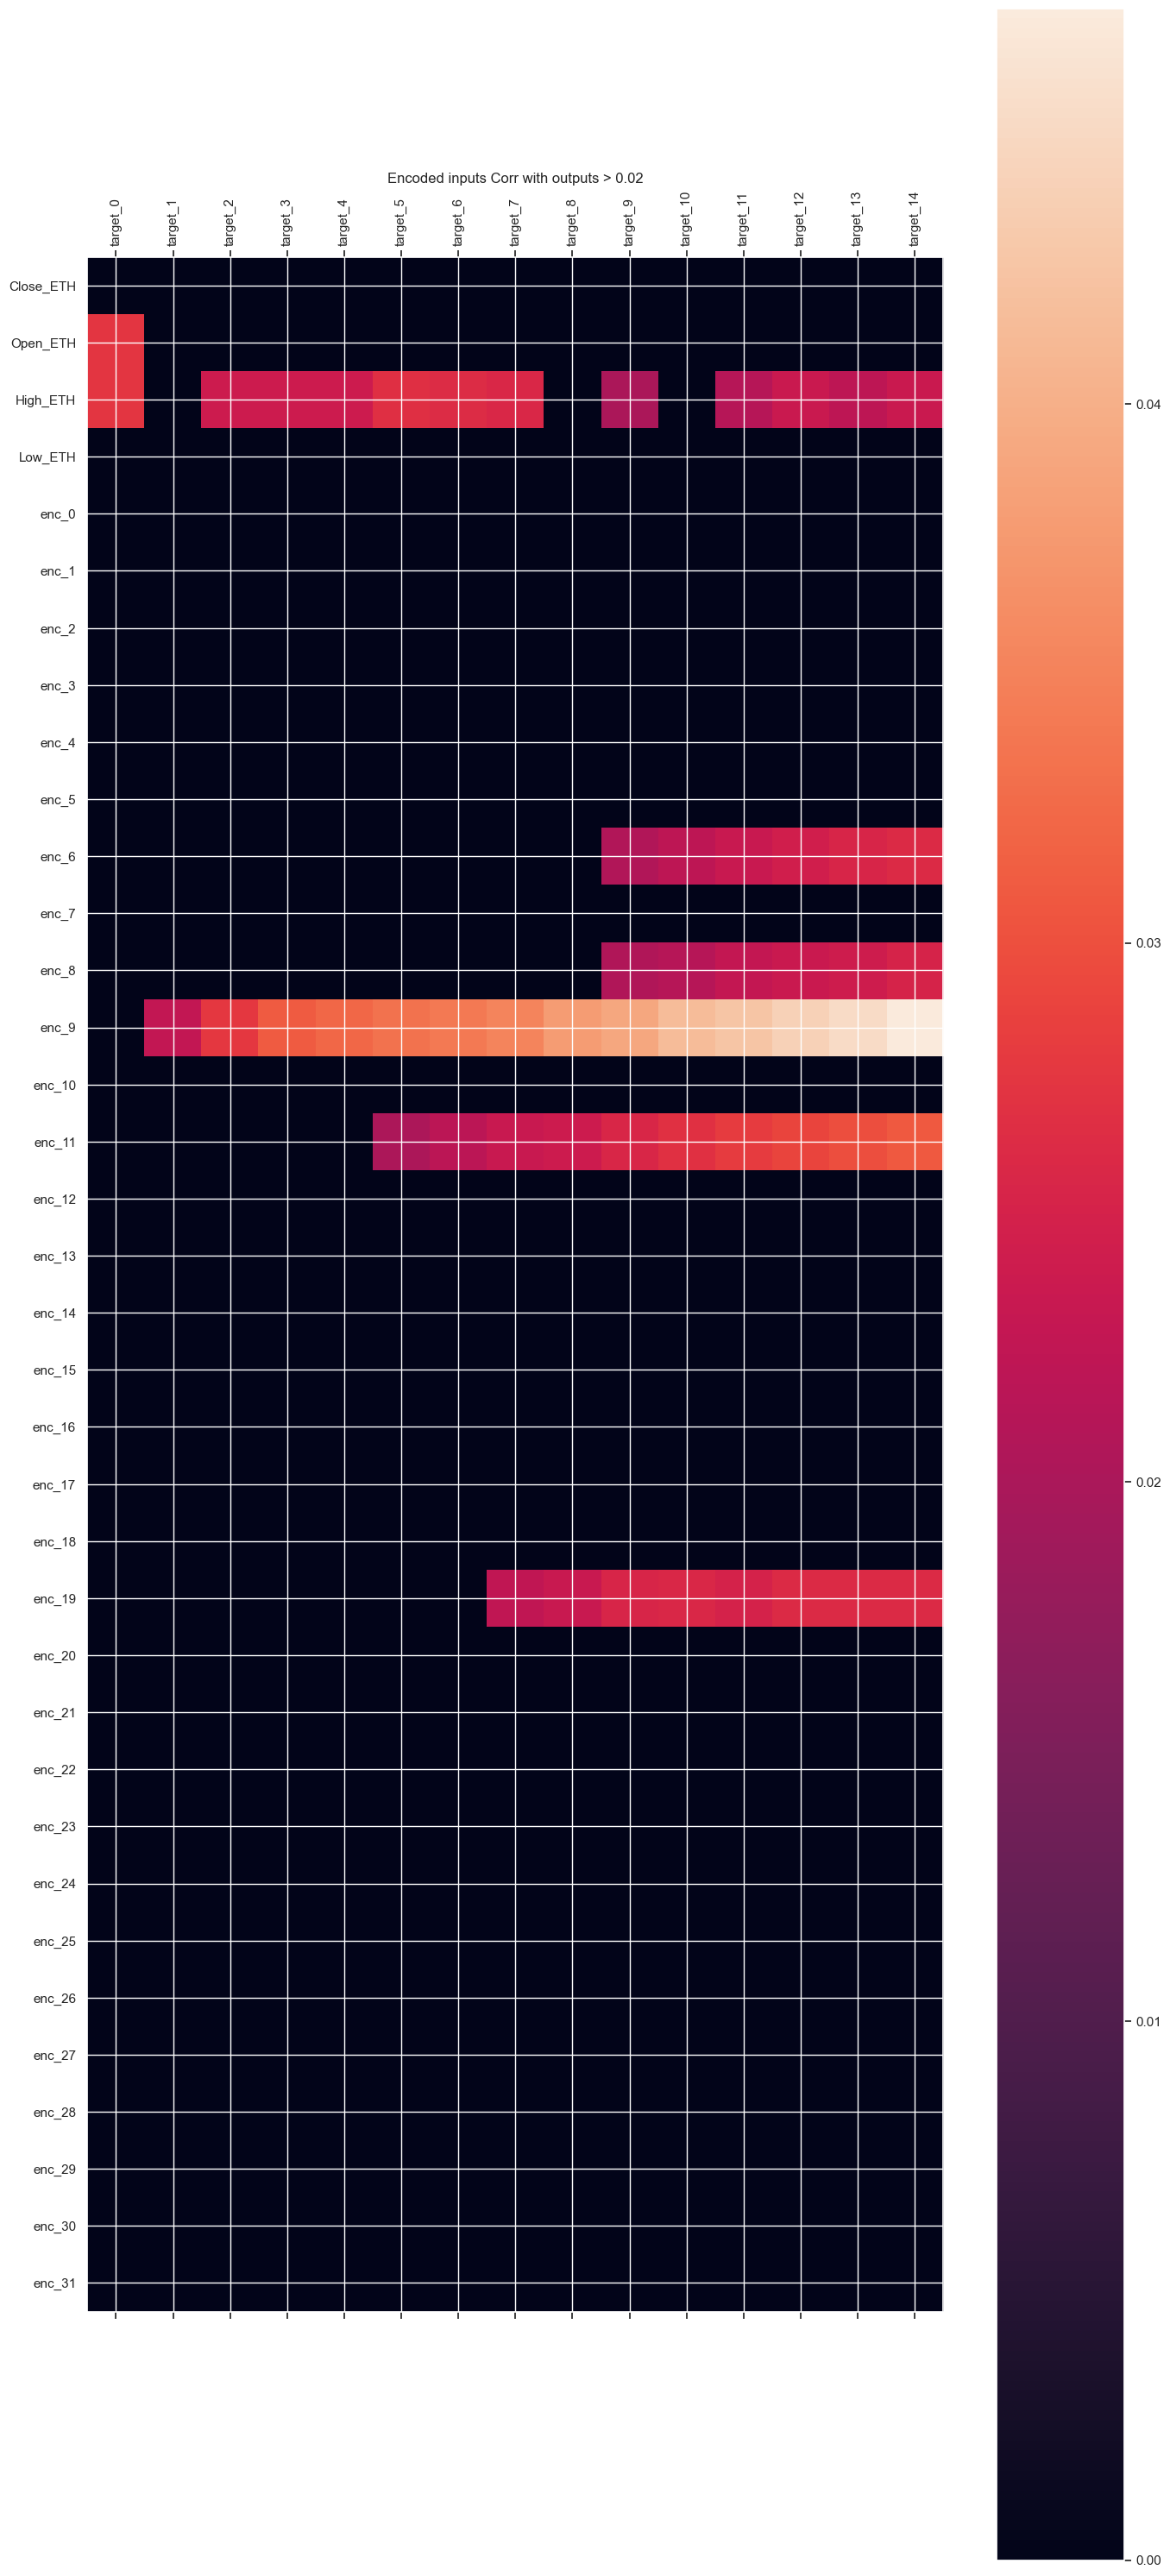

In [118]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

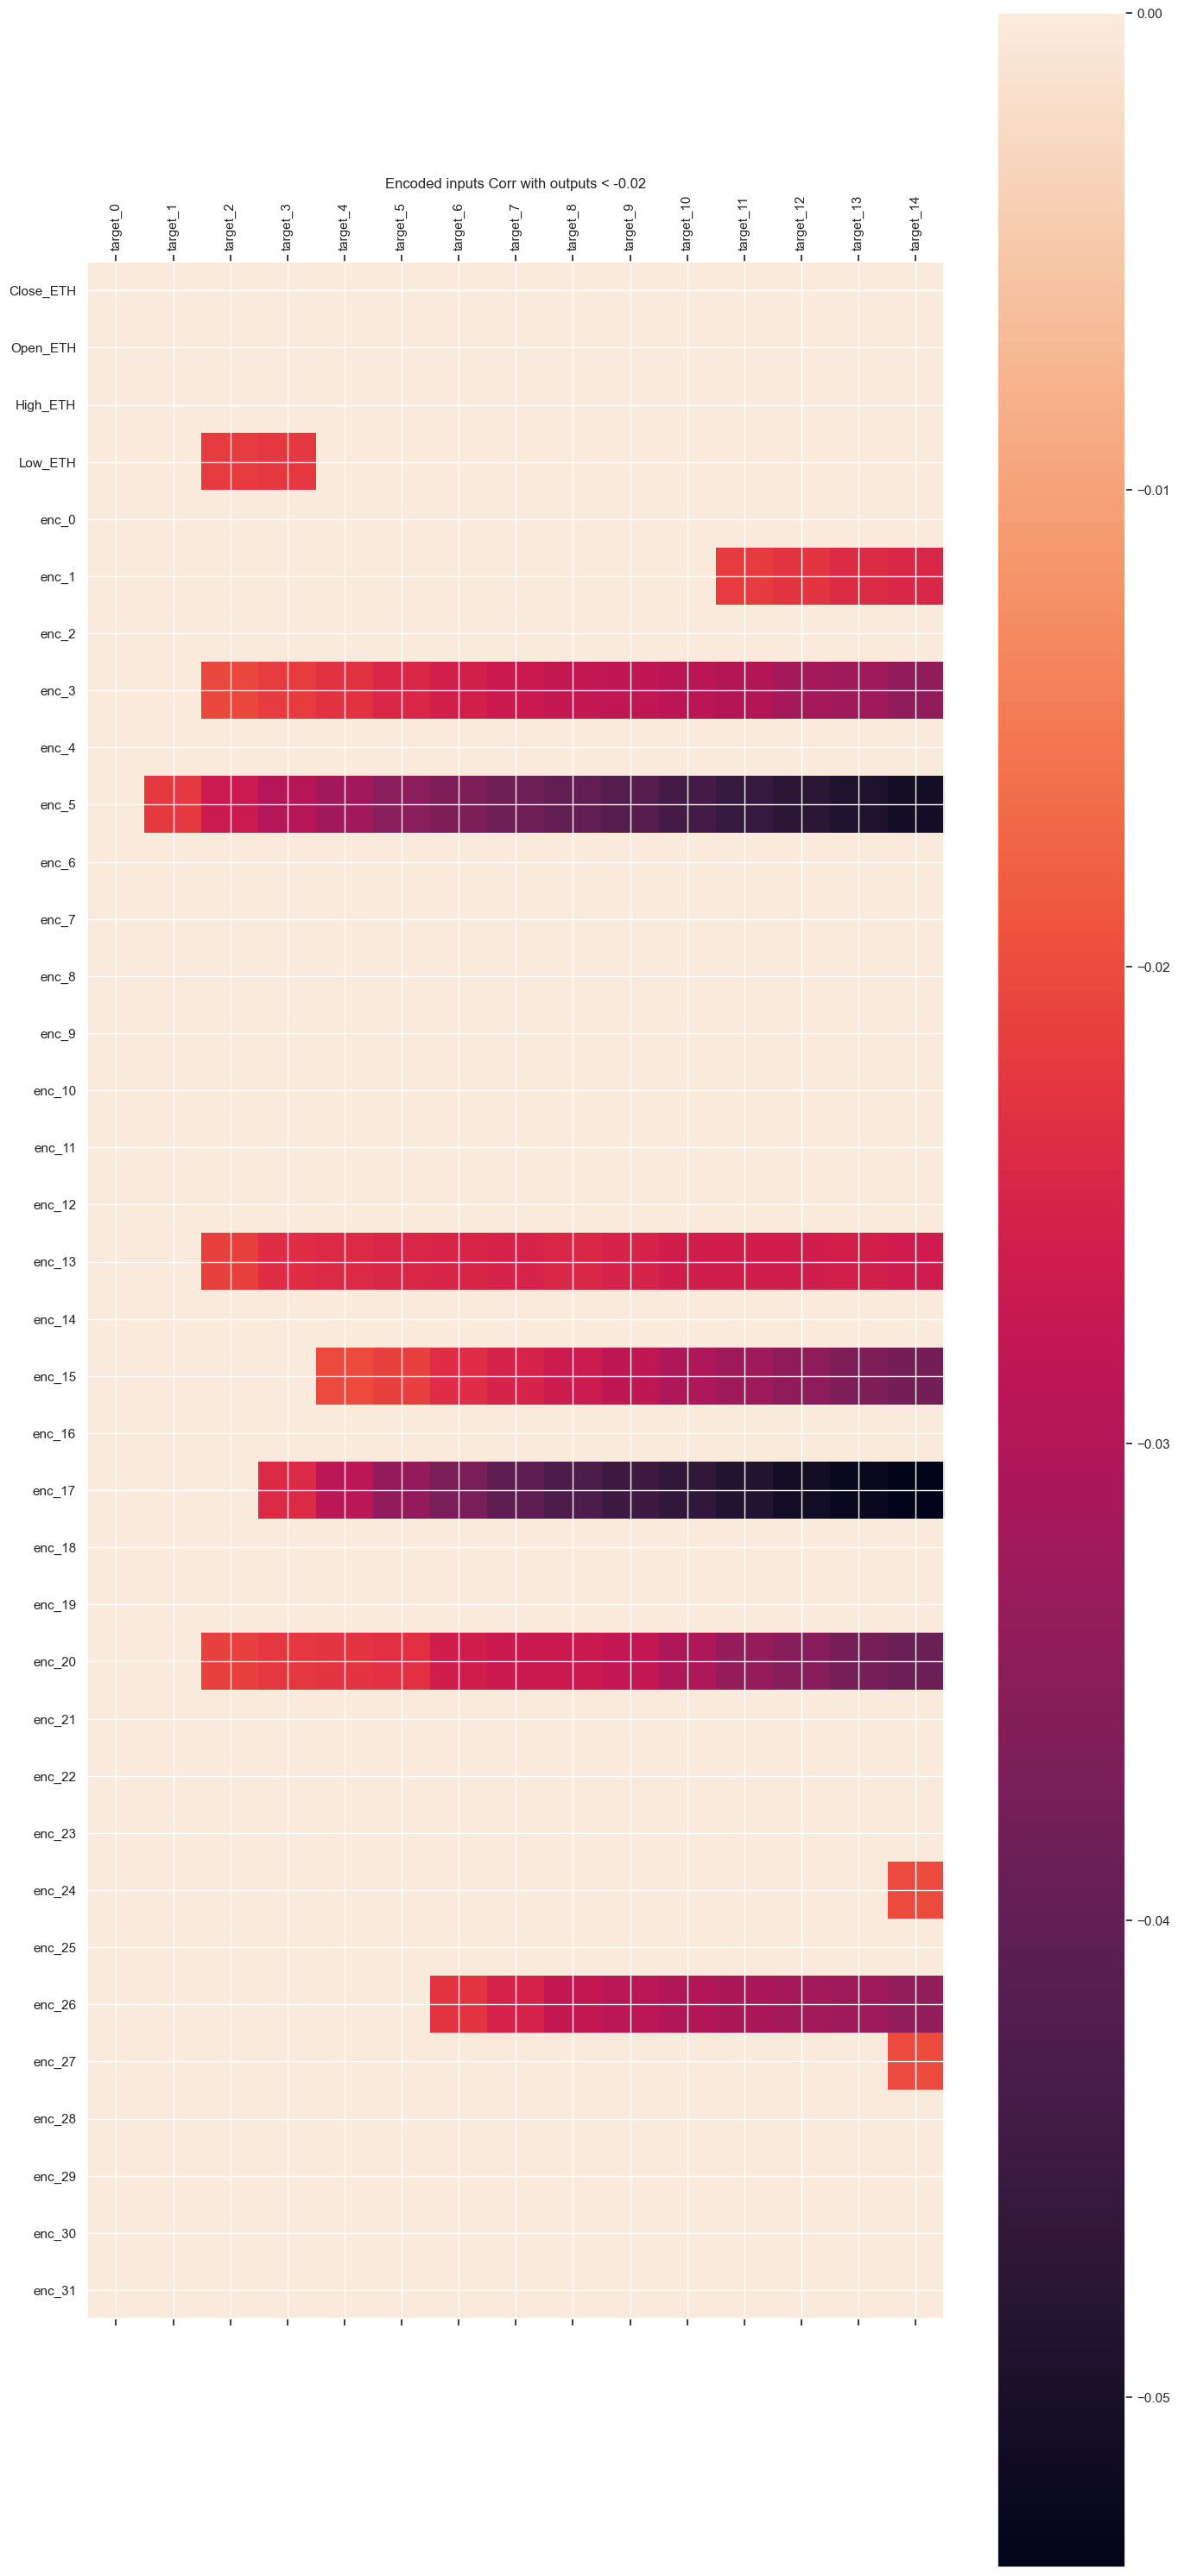

In [119]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [120]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [121]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [122]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [123]:
MODE_AUTO_SELECT

2

In [124]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]
nb encoded features:  15


In [125]:
X_train_.shape

(52920, 48, 36)

In [126]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  5,  7,  9, 10, 12, 13, 15, 17, 19, 21, 23, 24, 28,
       30, 31])

In [127]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [128]:
X_train_.shape

(52920, 48, 19)

#### Train

In [129]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 16#30
patience = 0#10
dropout_rate = 0.1#0.1
n_units = 128#32
seed = 1

if MODE_TRAIN_PREDICTOR:

    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    #optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
    #                      nesterov=nesterov)
    optim = tf.optimizers.Adam()
    if patience is not None:
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                        verbose=1, patience=patience,
                                        restore_best_weights=True)
    # create model
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(
        n_units,
        return_sequences=False,
        input_shape=X_train_.shape[-2:],
        )
    )
    multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
    #multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.LayerNormalization())
    multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1,
        )
    else:
        multi_step_history = multi_step_model.fit(
            X_train_, y_train_sca, epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_, y_test_sca), 
            verbose=1, 
            callbacks=[es],
        )
    # eval
    mse_curr = np.min(multi_step_history.history['val_loss'])
    print("MSE TEST : ", mse_curr)

    # plot MSE
    name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
    plot_train_history(
        multi_step_history,
        f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt}",
        saveFolder="data",
    )


if MODE_TRAIN_PREDICTOR:
    print("Save model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model.save(path_mdl_predict_autoenc_lstm)
else:
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               75776     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 77,967
Trainable params: 77,967
Non-trainable params: 0
_________________________________________________________________
None


#### Results

Save mdl

In [130]:
X_train_.shape

(52920, 48, 19)

Predict

In [131]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

17/17 [==============================] - 0s 12ms/step


Plots

In [132]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(52920,)
(52920,)


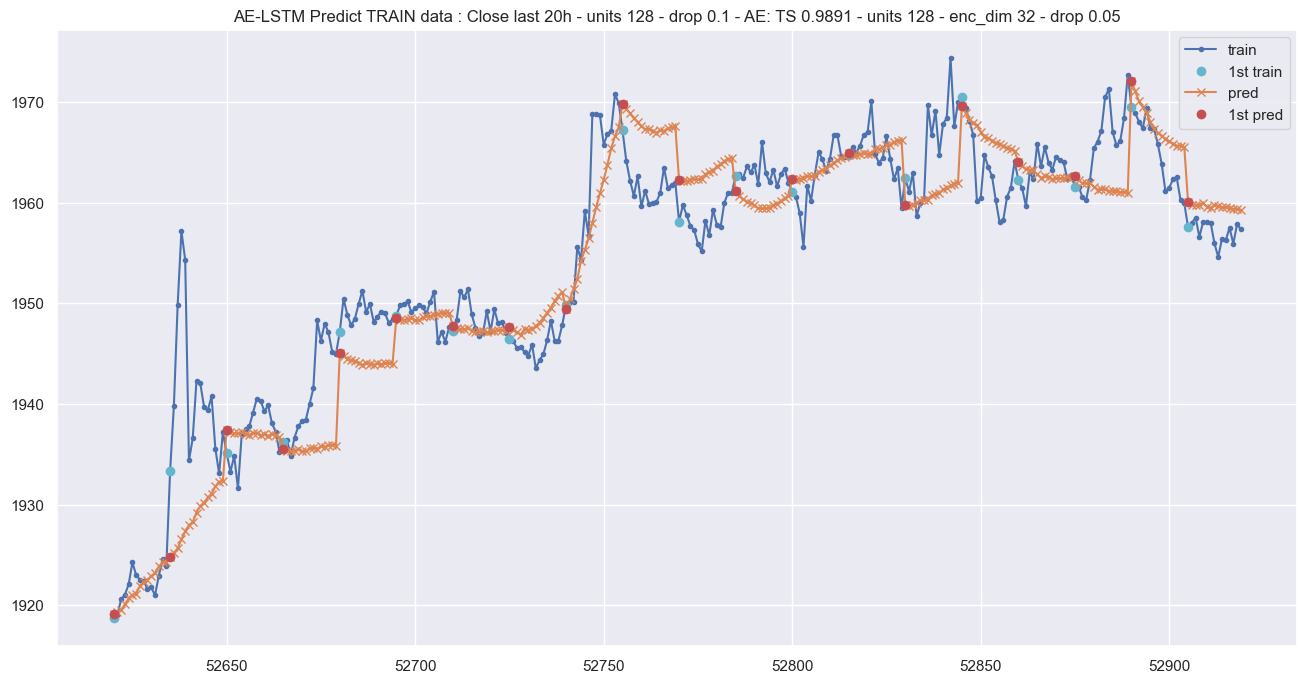

In [133]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

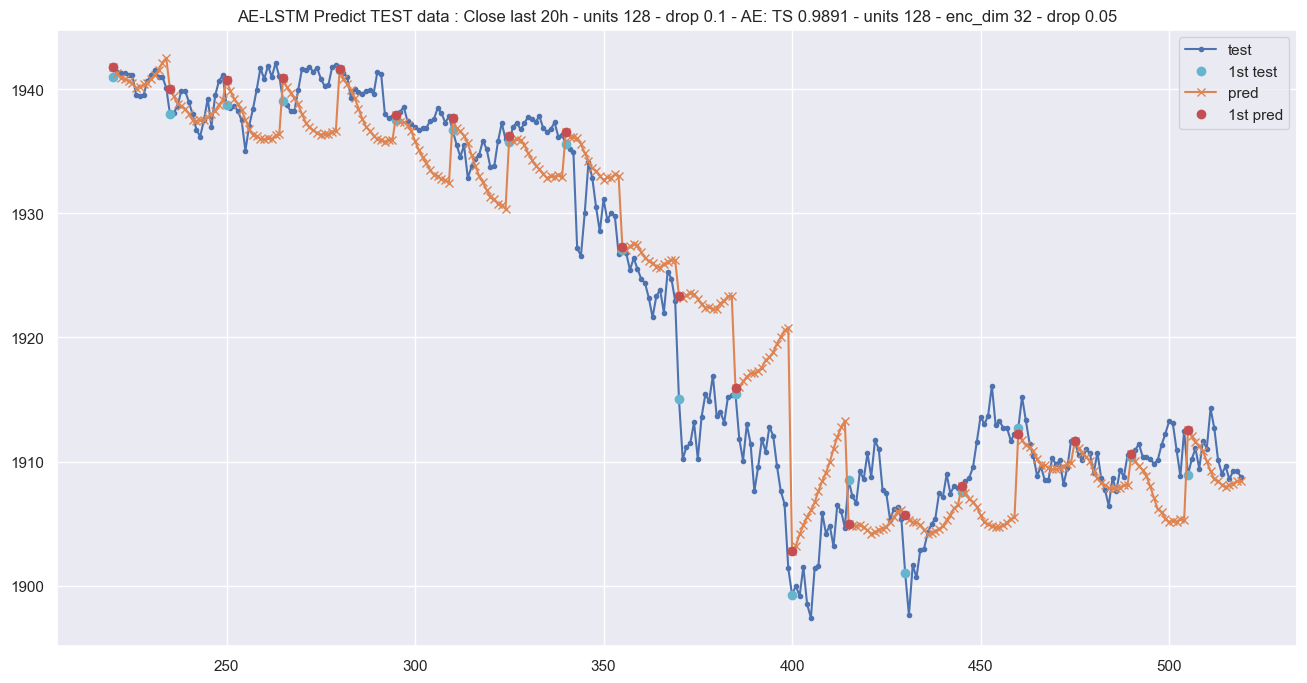

In [134]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

In [135]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

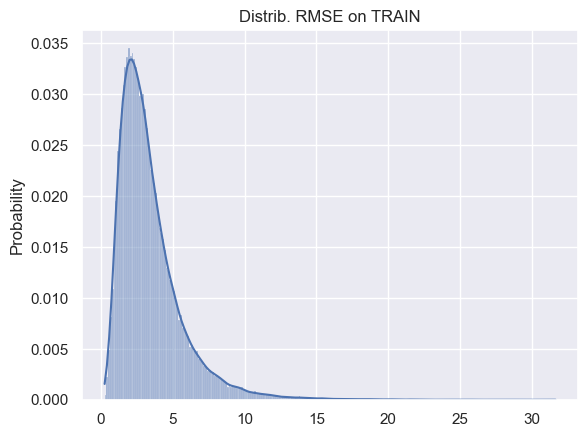

In [136]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 3.44')

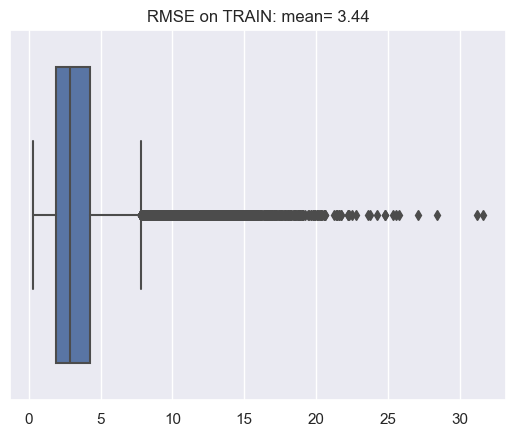

In [137]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

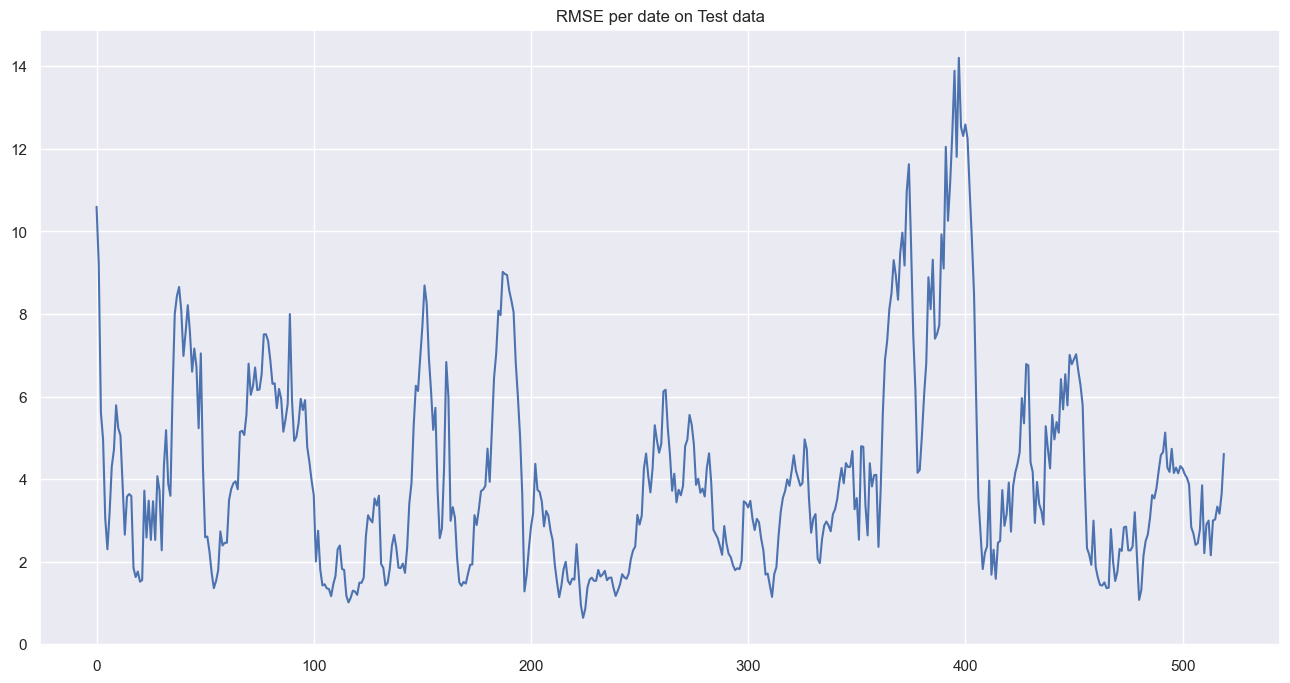

In [138]:
arr_mse = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="mse")

<AxesSubplot: ylabel='Probability'>

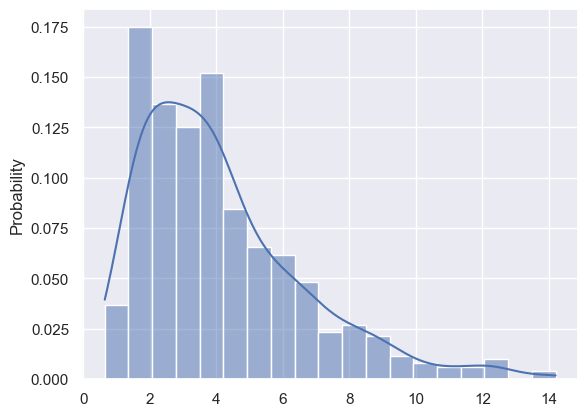

In [139]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)

Text(0.5, 1.0, 'RMSE on TEST: mean= 4.13')

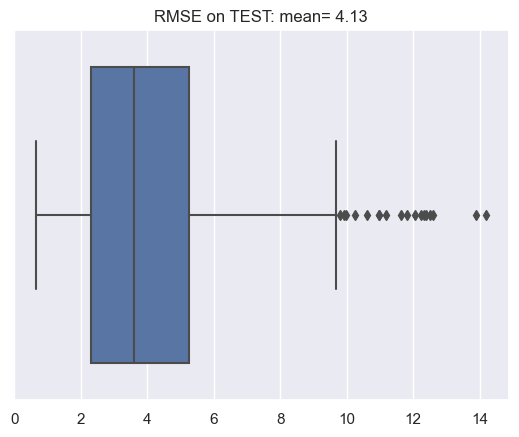

In [140]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [141]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1912.67 1910.12 1909.02 1909.61 1908.56 1909.25 1909.23 1908.79 1907.02
 1907.94 1908.23 1910.7  1914.62 1914.33 1912.75]
[1913.96063416 1913.1930836  1912.55515061 1912.0629233  1911.42944021
 1910.60255766 1909.66967623 1908.86584188 1908.65669662 1908.27971028
 1908.07330342 1908.11780241 1907.97700304 1908.28473068 1908.25438009]


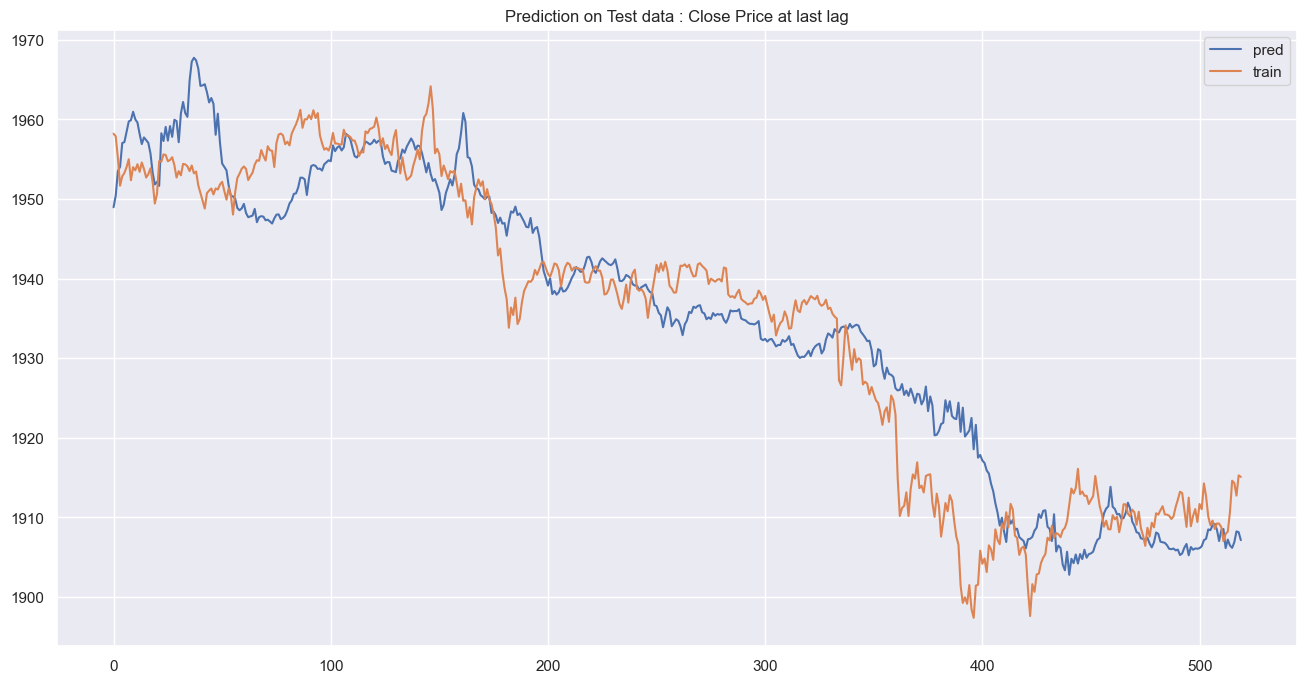

In [142]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

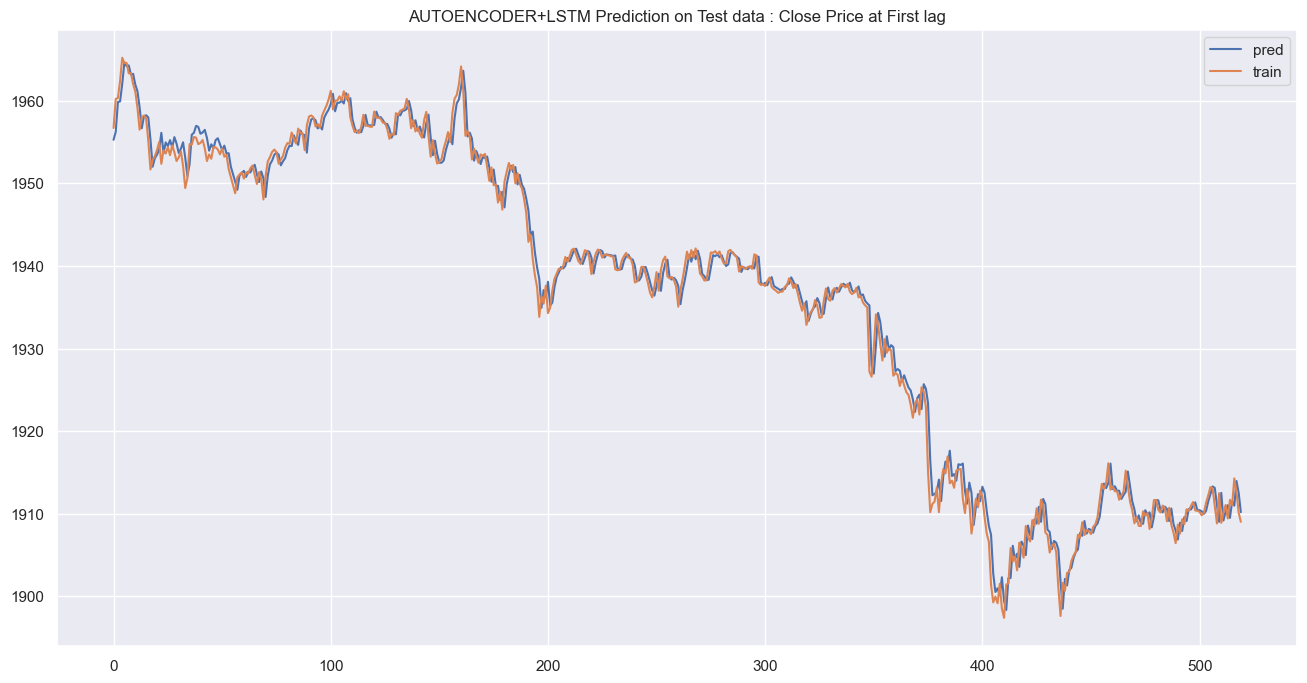

In [143]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

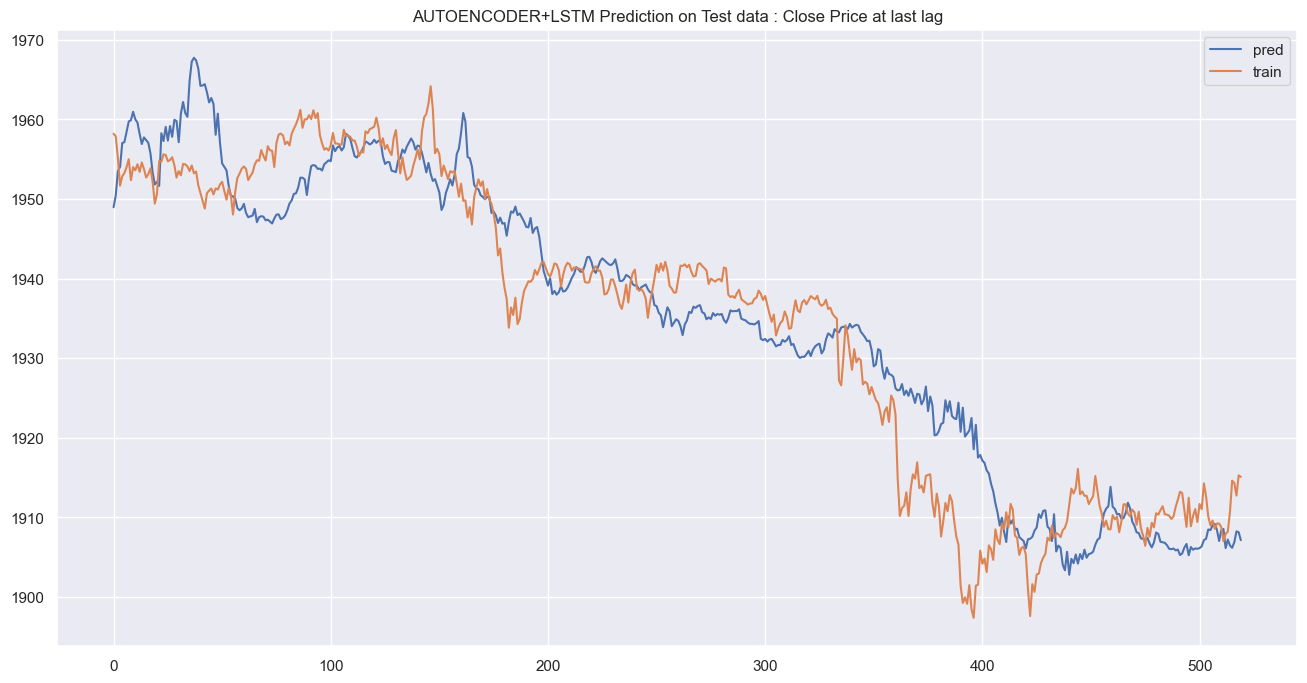

In [144]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [145]:
X_test_sca.shape

(520, 48, 104)

In [146]:
df_feat["Close_ETH"].iloc[-1]

1914.23

In [147]:
df_feat["Close_ETH"].iloc[-1]

1914.23

In [148]:
len(list_i_enc_select)

15

In [149]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1908.65 1907.71 1906.44 1908.7  1907.59 1909.34 1908.76 1910.53 1910.36
 1910.92 1911.42 1910.39 1910.36 1910.22 1909.81 1910.13 1911.33 1912.23
 1913.23 1913.07 1910.91 1908.82 1912.49 1908.9  1910.18 1911.06 1909.43
 1911.69 1911.04 1914.28 1912.67 1910.12 1909.02 1909.61 1908.56 1909.25
 1909.23 1908.79 1907.02 1907.94 1908.23 1910.7  1914.62 1914.33 1912.75
 1915.29 1915.1  1914.23]
X_last[0,:,0] after divide by price:
[0.99708499 0.99659393 0.99593048 0.99711111 0.99653124 0.99744545
 0.99714245 0.99806711 0.9979783  0.99827085 0.99853205 0.99799397
 0.9979783  0.99790516 0.99769098 0.99785815 0.99848503 0.99895519
 0.9994776  0.99939401 0.99826562 0.9971738  0.99909102 0.99721559
 0.99788427 0.99834398 0.99749246 0.9986731  0.99833353 1.00002612
 0.99918505 0.99785292 0.99727828 0.9975865  0.99703797 0.99739843
 0.99738798 0.99715813 0.99623347 0.99671408 0.99686558 0.99815592
 1.00020374 1.00005224 0.99922684 1.00055375 1.00045449 1.      

In [150]:
X_last_encoded_sca.shape

(1, 48, 32)

In [151]:
list_i_enc_select

[1, 3, 5, 6, 8, 9, 11, 13, 15, 17, 19, 20, 24, 26, 27]

In [152]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 48, 15)

In [153]:
X_last_sca[:,:,0:4].shape

(1, 48, 4)

In [154]:
X_train_.shape

(52920, 48, 19)

In [155]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
53561  1688599500000   1914.61   1914.93  1913.51    1914.33    451.4832   
53562  1688599800000   1914.33   1914.33  1912.15    1912.75    458.3916   
53563  1688600100000   1912.76   1915.58  1912.75    1915.29    595.6626   
53564  1688600400000   1915.29   1915.30  1914.62    1915.10    312.3015   
53565  1688600700000   1915.10   1915.46  1914.14    1914.23    242.9802   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.532907       1726.877911   
1      2023-01-01 00:05:00       1727.532907       1726.877911   
2      2023-01-01 00:10:00       1727.532907       1726.877911   
3      2023-01-01 00:15:00       1727.532907       1726.877911   
4      2023-01-01 00:20:00       1727.532907       1726.877911   
...                    ...               ...               ...   
53561  2023-07-05 23:25:00       1909.702500       1911.015000   
53562  2023-07-05 23:30:00       1909.815000       1911.015000   
53563  2023-07-05 23:35:00       1909.935000       1911.015000   
53564  2023-07-05 23:40:00       1909.935000       1911.015000   
53565  2023-07-05 23:45:00       1909.912500       1911.015000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
53561        1911.125  ...         NaN            NaN           NaN   
53562        1911.125  ...         NaN            NaN           NaN   
53563        1911.125  ...         NaN            NaN           NaN   
53564        1911.125  ...         NaN            NaN           NaN   
53565        1911.125  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
53561               NaN         0.0               NaN         0.0      0.0   
53562               NaN         0.0               NaN         0.0      0.0   
53563               NaN         0.0               NaN         0.0      0.0   
53564               NaN         0.0               NaN         0.0      0.0   
53565               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
53561                  NaN  False  
53562                  NaN  False  
53563                  NaN  False  
53564                  NaN  False  
53565                  NaN  False  

[53566 rows x 136 columns]

In [156]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [157]:
y_last_pred_unscaled

array([[0.99986756, 0.9994983 , 0.9991667 , 0.99887365, 0.9985464 ,
        0.9981037 , 0.99767715, 0.99738646, 0.9972688 , 0.9971177 ,
        0.9970213 , 0.9970216 , 0.9970045 , 0.9971223 , 0.9971439 ]],
      dtype=float32)

In [158]:
df_feat["Close_ETH"].iloc[-1]

1914.23

In [159]:
y_last_pred_raw

array([[1913.9764, 1913.2697, 1912.6349, 1912.0739, 1911.4475, 1910.6   ,
        1909.7834, 1909.227 , 1909.0018, 1908.7126, 1908.5281, 1908.5287,
        1908.496 , 1908.7214, 1908.7628]], dtype=float32)

In [160]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [161]:
list_pred

[1912.0739,
 1911.4475,
 1910.6,
 1909.7834,
 1909.227,
 1909.0018,
 1908.7126,
 1908.5281,
 1908.5287,
 1908.496,
 1908.7214,
 1908.7628]

In [162]:
save_list(list_pred, path_save_pred_vals)

In [163]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [164]:
list_pred_reload

[1912.0739,
 1911.4475,
 1910.6,
 1909.7834,
 1909.227,
 1909.0018,
 1908.7126,
 1908.5281,
 1908.5287,
 1908.496,
 1908.7214,
 1908.7628]